Interpolation des thermo-mosaïque en température du sol Requiert le pré-chargement des thermo-mosaïques (.tif) en DataFrame et des variogrammes afin de fonctionner. Calcul des modèles de covariance et permet des créer des sauvegardes des résultats interpolés ( créer le dossier ./varr/Estimate et ./varr/cross_valid) et de runner une cross-vérification ( très couteux en temps ).

In [2]:
import matplotlib as matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
import sys
import numpy as np
import sklearn as sklearn
import os
import scipy
from scipy import stats
from tqdm import tqdm
from scipy.spatial import distance_matrix
from sklearn.metrics import mean_squared_error
from tools_AA_IR import get_tif, reading_gps_file
from tools_AA import slice_raw, path_sonde
from tools_EL import readingtemp
from scipy.optimize import minimize
import geostatspy.geostats as geostats 
import seaborn as sns
import rasterio as rio 
from rasterio.plot import plotting_extent

In [3]:
def dict_temp_sensor_function(date_1,date_2) :
    """
    fonction créant un dictionnaire regroupant les DATAFRAMES tronquées aux dates souhaitées 
    """
    
    ls_path = path_sonde()
    dict_temp_sensor = {}
    for i,ls_path_sonde in enumerate(ls_path):
        name = ls_path_sonde[0][ls_path_sonde[0].find("S"):(ls_path_sonde[0].find(".csv"))]
        Raw = readingtemp(ls_path_sonde[0])
        if name == "S3AIR" : #différence entre le nom du fichier et le reste du code.
            name = "S3-AIR"
        dict_temp_sensor[name] = slice_raw(Raw,date_1,date_2)
        print("completed :",name)
    
    return dict_temp_sensor

    

In [4]:
def Import_variogram(REQUESTED_IR,TEMP,TYPE) :
    """
    Importation des données de variogrammes pré-calculés
    variogram : dictionnaire contenant différents données issus du calcul des variogrammes
    DataFrame : DataFrame contenant positions + valeurs 
    varc      : Variogrammes aux formats DataFrames
    """
    if TYPE == "Primary" :
        filename  = "./varr/Primary_variogram/Boucle/"+str(REQUESTED_IR)+"_"+str(TEMP)+".npy"
        variogram = np.load(filename,allow_pickle='TRUE').item()
        DataFrame = variogram["DataFrame"]
        varc      = variogram["Variogram"]
    
    elif TYPE == "Secondary" :
        filename  = "./varr/Secondary_variogram/Boucle/"+str(REQUESTED_IR)+"_convex.npy"
        #filename = "./varr/Secondary_variogram/Boucle/"+str(REQUESTED_IR)+"_ech10_convex.npy" 
        variogram = np.load(filename,allow_pickle='TRUE').item()
        DataFrame = variogram["DataFrame"]
        varc      = variogram["Variogram"]
        
    elif TYPE == "Cross" :
        filename  = "./varr/Cross_variogram/Boucle/"+str(REQUESTED_IR)+"_"+str(TEMP)+".npy"
        variogram = np.load(filename,allow_pickle='TRUE').item()
        DataFrame = variogram["DataFrame"]
        varc      = variogram["Variogram"]
        
    return variogram,DataFrame,varc
        
        

In [5]:
def replace_plaque_pseudotemp(Secondary, Primary,
                              original_std_y, original_mean_y,
                              radius = 0.5,
                              cluster_label = "vis",cluster_group = 6) :
    """
    Fonction qui permet de discriminer les pixels avec un clustering (ici sur la bande visible) et qui remplace 
    la valeur du signal IR d'un groupe de cluster (groupe 6) par la pseudo-temp 
    """
    SensorName = Primary["SensorName"].values
    Secondary = Secondary
    cluster_dict = {"hsv" : "val_cluster_hsv",
                   "vis" : "cluster_label_vis"}
    
    print(f"Remplacement des valeurs dans un rayon de {radius} m autour des plaques pour le cluster n°{cluster_group} ({cluster_label})")
    for Sensor in SensorName :
        Primary_Sensor = Primary.loc[Primary["SensorName"] == Sensor]
        x = Primary_Sensor["x"].values.astype(float)[0]
        y = Primary_Sensor["y"].values.astype(float)[0]
        
        # groupe de clustering qui discrimine plutot bien les plaques
        exp  = "X >= " + str(x-radius) + ' & ' + "X <= " + str(x+radius) + " & "
        exp += "Y >= " + str(y-radius) + ' & ' + "Y <= " + str(y+radius) + " & "
        exp += cluster_dict[cluster_label] + ' == ' +str(cluster_group) 
        
        #print("Valeurs à remplacer : \n",Secondary.query(exp))
        
        Secondary.loc[Secondary.eval(exp), "band 1"] = Primary_Sensor["Pseudo_temp"].values[0]
        Secondary.loc[Secondary.eval(exp), "Secondary"] = (Primary_Sensor["Pseudo_temp"].values[0] -original_mean_y )/ original_std_y
        
        #print("valeurs remplacées : \n", Secondary.loc[Secondary["band 1"] == Primary_Sensor["Pseudo_temp"].values[0]] )
        
        Secondary.loc[Secondary["band 1"] == Primary_Sensor["Pseudo_temp"].values[0]]
        
        #print("Completed : Sensor", Sensor, '\n \n')
    return Secondary

# Loading

### Importation des données

In [6]:
## Package d'importation 
dict_IR_Df = np.load("Custom_dict_IR_convex_space_26_07_ech_50.npy",allow_pickle='TRUE').item()
dict_IR_Df.keys()

dict_keys(['IR_6H55', 'IR_7H29', 'IR_8H22', 'IR_9H28', 'IR_10H22', 'IR_11H27', 'IR_12H31', 'IR_13H26', 'IR_15H59', 'IR_17H27'])

In [7]:
REQUESTED_IR = "IR_10H22"
TEMP = "T4"

## Données de température (Z)

In [8]:
Primary_variogram,Primary,varc_1 = Import_variogram(REQUESTED_IR,TEMP,"Primary") 
## Original Densifiée
Primary_original = Primary_variogram["DataFrame"]
## Primary Densifiée
Primary = Primary_variogram["DataFrame_dense"]

In [9]:
Primary.describe()

,x,y,Primary
count,99.000000,9.900000e+01,9.900000e+01
mean,523659.857465,5.366240e+06,2.512020e-16
std,24.986159,4.180064e+01,1.005089e+00
min,523626.746094,5.366173e+06,-2.145983e+00
25%,523639.905197,5.366210e+06,-4.858283e-01
50%,523652.863398,5.366246e+06,-1.097798e-01
75%,523690.633038,5.366277e+06,8.339040e-01
max,523696.655000,5.366298e+06,1.100701e+00


In [156]:
## En cas de sauvegarde, comparaison sur Surfer
condition = False
if condition :
    Primary_variogram["DataFrame"].to_csv("test_krg.csv")

## Données du drone (Y)

In [13]:
Secondary_variogram,Secondary,varc_2 = Import_variogram(REQUESTED_IR,TEMP,"Secondary") # seul le variogram est gardé
varc_2 = varc_2.dropna(axis = 0)

### Dataset spéciale contenant les IR echantillonée et les groupes de cluster

In [72]:
dict_IR_Df = np.load("Custom_dict_IR_convex_space_26_07_ech_50.npy",allow_pickle='TRUE').item()
Secondary = dict_IR_Df[REQUESTED_IR]["Secondary"]

#### Ré-echantillonage du DataFrame et re-indexing

In [73]:
## Re-enchantillonage
ech = 2
Secondary = Secondary.dropna(axis = 0)
Secondary = Secondary[::ech]
Secondary = Secondary.reset_index(drop=True)

In [74]:
Secondary.shape

(248956, 6)

In [79]:
original_std_y = Secondary["band 1"].std()
original_var_y = Secondary["band 1"].var()
original_mean_y = Secondary["band 1"].mean()

## Données croisées (ZY)

#### Rajout d'une colonne Secondary au DataFrame Primary

In [81]:
Cross_variogram,Cross,varc_3 = Import_variogram(REQUESTED_IR,TEMP,"Cross") 
Primary = Cross_variogram["DataFrame_dense"] # Primary densifiée : 100 pts au lieu de 9
Primary_original = Cross_variogram["DataFrame"]

## Calcul du facteur de Pearson

In [83]:
corr = np.corrcoef(Primary_original["Primary"], Primary_original["Secondary"])[0, 1]
corr = float("{:.2f}".format(corr))

## Statistique des trois datasets

### Statistiques du dataset d'origine

In [90]:
original_std_z = float("{:.0f}".format(Primary_original[TEMP].std()))
original_var_z = float("{:.0f}".format(Primary_original[TEMP].var()))
original_mean_z = float("{:.0f}".format(Primary_original[TEMP].mean()))
std_z = float("{:.0f}".format(Primary_original["Primary"].std()))
std_y = float("{:.0f}".format(Secondary["Secondary"].std()))
var_z = float("{:.0f}".format(Primary_original["Primary"].var()))
var_y = float("{:.0f}".format(Secondary["Secondary"].var()))
mean_z = float("{:.0f}".format(Primary_original["Primary"].mean()))
mean_y = float("{:.0f}".format(Secondary["Secondary"].mean()))

In [85]:
print("std of Z :", std_z)
print("std of Y :",std_y)
print("var of Z :", var_z)
print("var of Y :",var_y)
print("mean of Z :", mean_z)
print("mean of Y :",mean_y)
print("Cross Correlation coefficient :",corr,"\n")

print("Original std of Z :", original_std_z)
print("Original std of Y :",original_std_y)
print("Original var of Z :", original_var_z)
print("Original var of Y :",original_var_y)
print("Original mean of Z :", original_mean_z)
print("Original mean of Y :",original_mean_y)

std of Z : 1.0
std of Y : 1.0
var of Z : 1.0
var of Y : 1.0
mean of Z : 0.0
mean of Y : 0.0
Cross Correlation coefficient : 0.72 

Original std of Z : 1.3397569742307744
Original std of Y : 2.174361802179387
Original var of Z : 1.79494875
Original var of Y : 4.727849246776792
Original mean of Z : 6.463666666666667
Original mean of Y : 11.2140192640129


## Suppression des effets des plaques proche des sondes

In [86]:
Secondary = replace_plaque_pseudotemp(Secondary, Primary_original, original_std_y, original_mean_y)

Remplacement des valeurs dans un rayon de 0.5 m autour des plaques pour le cluster n°6 (vis)


## Visualisation du signal IR

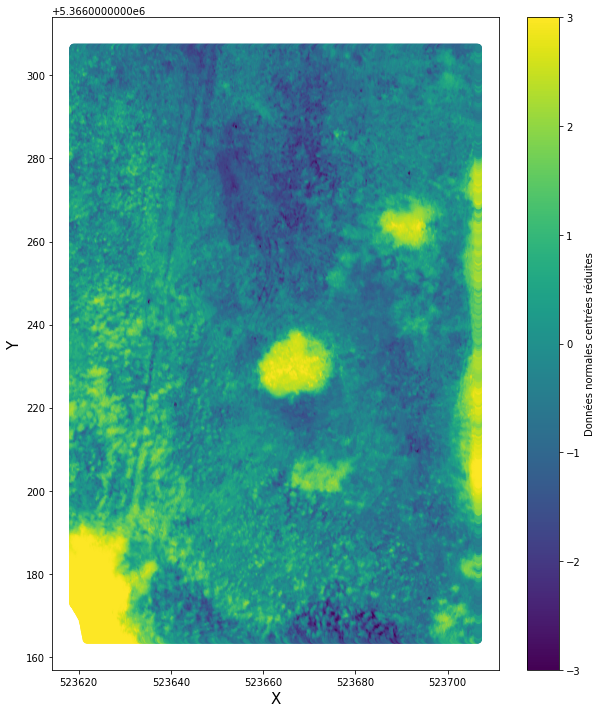

In [1201]:
condition = False
Secondary.head()
X = Secondary["X"].values 
Y = Secondary["Y"].values 
Z = Secondary["Secondary"].values 
if condition :
    # On check les matrices crées, prend du temps à zaper si on s'en fout
    ech = 1
    fig,ax=plt.subplots(1,1, figsize = (10,12))
    img0 = ax.scatter(X[::ech],Y[::ech],c = Z[::ech],vmin = -3, vmax = 3)
    ax.set_xlabel('X', size = 15)
    ax.set_ylabel('Y', size = 15)
    #ax.grid()
    fig.colorbar(img0, ax=ax,label = "Données normales centrées réduites")

## Visualisation des Correlogrammes

In [1202]:
condition = False
if condition :
    
    ones = np.zeros(shape=(100))
    Cross_ones = np.zeros(shape=(100))
    H = np.zeros(shape=(100))
    Corr_labels = [
        "Primary Correlogram",
        "Secondary Correlogram",
        "Cross Correlogram",
    ]
    Directions = ["Major", "Minor"]
    colors = ["Grey", "Blue", "Orange"]
    labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]
    Sill_vals = [var_z, var_y, corr]

    for h in range(1, 100):
        H[h] = h
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i in range(0, 3):
        var = locals()["varc_{}".format(i + 1)]
        for j in range(0, 2):
            axes[j, i].plot(
                var["Lag Distance"][var["Variogram Index"] == (j + 1)],
                Sill_vals[i]
                - var["Variogram Value"][var["Variogram Index"] == (j + 1)],
                "o",
                color=colors[i],
            )
            axes[j, i].set_ylabel(labels_2[i], size=35)
            axes[j, i].plot(H, ones, color="Black")
            axes[j, i].set_xlabel("h", size=35)
            axes[j, i].set_title(Corr_labels[i] + " " + Directions[j] +"\n"+ REQUESTED_IR +' : '+ TEMP, size=15)
    plt.setp(axes, xlim=(0, 100))
    plt.tight_layout()

    #plt.savefig('true_variograms.png', bbox_inches="tight", dpi=300)

# En cas de cokrigeage / calcul de cross-verification avec des modèles de covariance pré-existant, lancer jusqu'aux functions de calcul de covariance puis passer à la fin 

# Correlogram Model 

In [58]:
def covar(t, d, r):
    """
    Fonction qui calcul divers structures de covariance (correlogram)
    """
    h = d / r 
    if t == 1:  # Spherical
        c = (1 - h * (1.5 - 0.5 * np.square(h)))
        c[h > 1] = 0
    elif t == 2:  # Exponential
        c = (np.exp(-3 * h))
    elif t == 3:  # Gaussian
        c = (np.exp(-3 * np.square(h)))
    elif t == 4:  # Hole effect
        angle = 20 # degree
        omega = (angle / 180.0) * np.pi
        c = (np.exp(-3 * h)) * np.cos(omega*h)
    return c

In [59]:
def Rot_Mat(Azimuth, a_max, a_min):
    """
    Fonction qui permet d'effectuer une rotation des données afin de prendre en compte l'anisotropie du milieu
    """
    theta = (Azimuth / 180.0) * np.pi
    Rot_Mat = np.dot(
        np.array([[1 / a_max, 0], [0, 1 / a_min]]),
        np.array(
            [
                [np.cos(theta), np.sin(theta)],
                [-np.sin(theta), np.cos(theta)],
            ]
        ),
    )
    return Rot_Mat

### Correlogram function  (Z)

In [60]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_alternate(h1, h2, k,dict_C_Z,nstruct = 1, Azimuth = 45):
    C = []
    vtype = dict_C_Z["vtype"] # type de structure
    a_max = dict_C_Z["a_max"] # portée max
    a_min = dict_C_Z["a_min"] # portée min (similaire à max)
    cc = dict_C_Z["cc"] # effet de pépite
    c = 0
    #print(vtype,a_max,a_min,cc)
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i] # calcul à l'aide des structures de covariance
    return c

### Correlogram function  (Y)

In [61]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Y_alternate(h1, h2, k,dict_C_Y,nstruct = 1, Azimuth = 45):
    C = []
    vtype = dict_C_Y["vtype"]
    a_max = dict_C_Y["a_max"]
    a_min = dict_C_Y["a_min"] 
    cc = dict_C_Y["cc"]
    #Azimuth = 45
    c = 0.0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                )
            ).sum(axis=1)
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1)  * cc[i]

    return c

### Correlogram function  (Cross)

In [62]:
def C_ZY(h1, h2, k,dict_C_ZY,nstruct = 1,Azimuth = 45):
    C = []
    vtype = dict_C_ZY["vtype"]
    a_max = dict_C_ZY["a_max"]
    a_min = dict_C_ZY["a_min"] 
    cc = dict_C_ZY["cc"]
    #Azimuth = 45
    c = 0
    for i in range(nstruct):
        
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

### Scalling Correlogram : degrée de liberté

In [63]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_r (h1, h2, k, dict_C_r,nstruct = 1, Azimuth = 45 ):
    C = []
    vtype = dict_C_r["vtype"]
    a_max = dict_C_r["a_max"]
    a_min = dict_C_r["a_min"] 
    cc = dict_C_r["cc"]
    #Azimuth = 45
    c = 0
    for i in range(nstruct):
        Q1 = h1.copy()
        Q2 = h2.copy()
        if k == 0:
            d = distance_matrix(
                np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])),
                np.matmul(Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])),
            )
        elif k == 1:
            d = np.sqrt(
                np.square(
                    (np.matmul(Q1, Rot_Mat(Azimuth, a_max[i], a_min[i])))
                    - np.tile(
                        (
                            np.matmul(
                                Q2, Rot_Mat(Azimuth, a_max[i], a_min[i])
                            )
                        ),
                        (k, 1),
                    )
                ).sum(axis=1)
            )
            d = np.asarray(d).reshape(len(d))
        elif k == 2:
            d = Q1 / a_max[i]
        elif k == 3:
            d = Q1 / a_min[i]
        c = c + covar(vtype[i], d, 1) * cc[i]
    return c

### C_Z Correlogram MMII 

In [65]:
# h1 = Set of points X,Y
# h2 = Set of points X,Y
# Corr = correlation between primary and secondary data
# k = 0 used for calculating the distance between the same points
# k = 1 used for calculationg distance between different points
# k = 2 used for plotting in the major direction
# k = 3 used for plotting in the minor direction
def C_Z_MM2(h1, h2, k, corr,dict_secondary, dict_C_r ):
    
    return (C_Y_alternate(h1, h2, k,dict_secondary, nstruct = 1) * corr ** 2) + (
        (1 - corr ** 2) * C_r (h1, h2, k,dict_C_r,nstruct = 1 )
    )

### Pré-allocation des matrices

In [64]:
## Define some matrices for storing variogram values
LENGTH = 100
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
H = np.zeros(shape=(LENGTH + 1))
ones = np.zeros(shape=(LENGTH + 1))
Sill_vals = [std_z,std_y,corr] ## !!

### Plottting labels 
colors = ["Red", "Green","Blue"]
labels_2 = ["$\u03C1_{z}$", "$\u03C1_{y}$", "$\u03C1_{zy}$"]

Corr_labels = [
    "Primary Correlogram",
    "Secondary Correlogram",
    "Cross Correlogram"]

labels_1 = [
    "$\hat{\u03C1_{z}}$",
    "$\hat{\u03C1_{y}}$",
    "$\hat{\u03C1_{zy}}$",
]
labels_MM = [
    "$\u03C1_{z_{Model}}$",
    "$\u03C1_{y_{Model}}$",
    "$\u03C1_{z_{MMII}}$",
]

Cross_ones = np.zeros(shape=(101))


# Primary Model  (Z)

### Minimize function  (Z)

In [46]:
def optimize_RMSE_Z_model(x, args):
    """
    args : args[0] correspond au DataFrame des variogram, args[1] correspond aux valeurs de variance; 
    pour un modèle à plusieur couche => inserer en tant que list : a_max = [a_max1,a_max2].
    ex : gamma= b1*spherical(a_min[0],a_max[0]) + b2*gaussien(a_min[1],a_max[1])
    """
    
    var = args[0][args[0]["Variogram Value"] != -999]
    var = var.dropna(axis = 0)
    
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    # Modèle à une structure
    if len(x0) == 3 :
        a_max_z_0 = [x[0]]         # range
        a_min_z_0 = [x[1]]
        cc_z_0 = [x[2]]            # effet pépite
        MODEL_value = [args[2]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_z_0 = x[0::3]        # range
        a_min_z_0 = x[1::3]
        cc_z_0 = x[2::3]           # effet pépite
        MODEL_value = args[2::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_primary_0 = {"a_max" : a_max_z_0
                ,"a_min" : a_min_z_0
                ,"cc" : cc_z_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_primary_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_Z_alternate(np.matrix(h), np.matrix(h), k, dict_primary_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [1209]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3,
            "Hole effect" : 4}

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_z_0 = np.array([40])
a_min_z_0 = np.array([40])
cc_z_0    = np.array([1])
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_1, Sill_vals[0] # variogram , Variance
nstruct = len(a_max_z_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_z_0[i]
    b = a_min_z_0[i]
    c = cc_z_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,1]]
if nstruct > 1 :
    Bounds *=  len(a_max_z_0)


# Minimize
Z_model = minimize(optimize_RMSE_Z_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(Z_model)

a_max_z = [float("{:.0f}".format(x)) for x in Z_model.x[0::3]]
a_min_z = [float("{:.0f}".format(x)) for x in Z_model.x[1::3]]
cc_z = [float("{:.2f}".format(x)) for x in Z_model.x[2::3]]

dict_primary = {"a_max" : a_max_z
                ,"a_min" : a_min_z
                ,"cc" : cc_z
                ,"vtype" : MODEL_value,
                "nstruct" : nstruct
}

{'a_max': [40.0], 'a_min': [40.0], 'cc': [1.0], 'vtype': [1]}
RMSE : [0.9151009831951239, 0.9151009831951239] 

{'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': [1.0], 'vtype': [1]}
RMSE : [0.9151002161671373, 0.9151009831951239] 

{'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': [1.0], 'vtype': [1]}
RMSE : [0.9151017502321844, 0.9151009831951239] 

{'a_max': [40.0], 'a_min': [39.999757781821906], 'cc': [1.0], 'vtype': [1]}
RMSE : [0.9151009831951239, 0.9151002161671373] 

{'a_max': [40.0], 'a_min': [40.000242218178094], 'cc': [1.0], 'vtype': [1]}
RMSE : [0.9151009831951239, 0.9151017502321844] 

{'a_max': [40.0], 'a_min': [40.0], 'cc': [0.9999939445455476], 'vtype': [1]}
RMSE : [0.9151010736421201, 0.9151010736421201] 

{'a_max': [40.0], 'a_min': [40.0], 'cc': [1.0000060554544523], 'vtype': [1]}
RMSE : [0.9151008927496052, 0.9151008927496052] 

{'a_max': [39.99999858793132], 'a_min': [39.99999858793132], 'cc': [1.0000000023681004], 'vtype': [1]}
RMSE : [0.9151009786881542,

{'a_max': [33.16996367422971], 'a_min': [33.16996367422971], 'cc': [1.9999878890910952], 'vtype': [1]}
RMSE : [0.8736771203324057, 0.8736771203324057] 

{'a_max': [33.16996367422971], 'a_min': [33.16996367422971], 'cc': [1.9999757781821905], 'vtype': [1]}
RMSE : [0.8736772872707942, 0.8736772872707942] 

{'a_max': [33.169962737187134], 'a_min': [33.169962737187134], 'cc': [2.0], 'vtype': [1]}
RMSE : [0.8736769499305235, 0.8736769499305235] 

{'a_max': [33.16976187798859], 'a_min': [33.169962737187134], 'cc': [2.0], 'vtype': [1]}
RMSE : [0.8736762067382623, 0.8736769499305235] 

{'a_max': [33.17016359638568], 'a_min': [33.169962737187134], 'cc': [2.0], 'vtype': [1]}
RMSE : [0.8736776931803606, 0.8736769499305235] 

{'a_max': [33.169962737187134], 'a_min': [33.16976187798859], 'cc': [2.0], 'vtype': [1]}
RMSE : [0.8736769499305235, 0.8736762067382623] 

{'a_max': [33.169962737187134], 'a_min': [33.17016359638568], 'cc': [2.0], 'vtype': [1]}
RMSE : [0.8736769499305235, 0.8736776931803606] 

###  Visualisation du model Z

In [1210]:
dict_primary

{'a_max': [31.0],
 'a_min': [31.0],
 'cc': [2.0],
 'vtype': array([1]),
 'nstruct': 1}

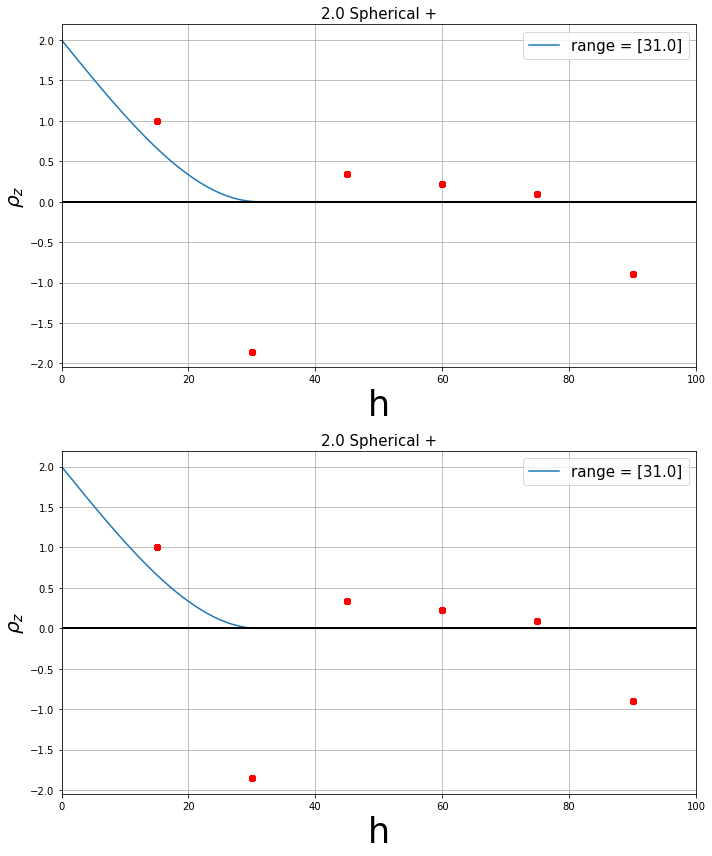

In [1211]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction
nstruct = dict_primary["nstruct"]
MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien",
        4 : "Hole effect"}


label_dict = {0: dict_primary["a_max"],
             1 : dict_primary["a_min"]}

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_primary["cc"],dict_primary["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_primary["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_primary["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1


fig, axes = plt.subplots(2,1, figsize=(10, 12))
cz_True = np.zeros(shape=(LENGTH + 1))
for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type, dict_primary,nstruct)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [0]:
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        for j in np.arange(1):
            axes[s].plot(
                var["Lag Distance"][var["Variogram Index"] == (s + 1)],
                Sill_vals[i]
                - var["Variogram Value"][var["Variogram Index"] == (s + 1)],
                "o",
                color=colors[i],
            )
            axes[s].set_ylabel(labels_2[i], size=20)
            axes[s].plot(H, ones, color="Black")
            axes[s].set_xlabel("h", size=35)
            axes[s].set_title(TITLE, size=15)
            axes[s].legend(loc="best", prop={"size": 15})
            axes[s].grid()
    plt.setp(axes, xlim=(0, 100))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

# Secondary Model  (Y)

In [1212]:
varc_2.head()

,Lag Distance,Number of Pairs,Variogram Value,Variogram Index
0,1.0,230168.0,0.116857,1.0
1,2.0,226492.0,0.228195,1.0
2,3.0,222817.0,0.286601,1.0
3,4.0,219149.0,0.334909,1.0
4,5.0,338847.0,0.387657,1.0


### Minimize function  (Y)

In [48]:
def optimize_RMSE_Y_model(x, args):

    var = args[0][args[0]["Variogram Value"] != -999]
    var = var.dropna(axis = 0)
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_y_0 = [x[0]]         # range
        a_min_y_0 = [x[1]]
        cc_y_0 = [x[2]]            # effet pépite
        MODEL_value = [args[2]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_y_0 = x[0::3]        # range
        a_min_y_0 = x[1::3]
        cc_y_0 = x[2::3]           # effet pépite
        MODEL_value = args[2::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_secondary_0 = {"a_max" : a_max_y_0
                ,"a_min" : a_min_y_0
                ,"cc" : cc_y_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_secondary_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_Y_alternate(np.matrix(h), np.matrix(h), k, dict_secondary_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [1215]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3 ,
        "Hole effect" : 4
            }

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_y_0 = np.array([40])
a_min_y_0 = np.array([40])
cc_y_0    = np.array([2])
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_2, Sill_vals[0] # variogram , Variance
nstruct = len(a_max_y_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_y_0[i]
    b = a_min_y_0[i]
    c = cc_y_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,5]]
if nstruct > 1 :
    Bounds *=  len(a_max_y_0)


Y_model = minimize(optimize_RMSE_Y_model,x0,args = args,
                            method='TNC', jac = '3-point',# Minimize
                            bounds = Bounds,tol = 1e-9)


print(Y_model)

a_max_y = [float("{:.0f}".format(x)) for x in Y_model.x[0::3]]
a_min_y = [float("{:.0f}".format(x)) for x in Y_model.x[1::3]]
cc_y = [float("{:.2f}".format(x)) for x in Y_model.x[2::3]]

dict_secondary = {"a_max" : a_max_y
                ,"a_min" : a_min_y
                ,"cc" : cc_y
                ,"vtype" : MODEL_value
                  ,"nstruct" : nstruct
}

{'a_max': [40.0], 'a_min': [40.0], 'cc': [2.0], 'vtype': [1]}
RMSE : [0.6050713432434839, 0.5274620592092671] 

{'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': [2.0], 'vtype': [1]}
RMSE : [0.605067902625777, 0.5274620592092671] 

{'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': [2.0], 'vtype': [1]}
RMSE : [0.6050747838536596, 0.5274620592092671] 

{'a_max': [40.0], 'a_min': [39.999757781821906], 'cc': [2.0], 'vtype': [1]}
RMSE : [0.6050713432434839, 0.5274586768311783] 

{'a_max': [40.0], 'a_min': [40.000242218178094], 'cc': [2.0], 'vtype': [1]}
RMSE : [0.6050713432434839, 0.5274654415802079] 

{'a_max': [40.0], 'a_min': [40.0], 'cc': [1.9999878890910952], 'vtype': [1]}
RMSE : [0.6050660305379325, 0.5274574547651978] 

{'a_max': [40.0], 'a_min': [40.0], 'cc': [2.0000121109089046], 'vtype': [1]}
RMSE : [0.6050766559505186, 0.5274666636539093] 

{'a_max': [39.99999359542363], 'a_min': [39.99999370383418], 'cc': [1.9999995897686362], 'vtype': [1]}
RMSE : [0.6050710723123481, 

RMSE : [0.044482968447366274, 0.06909296464833406] 

{'a_max': [25.67328848771458], 'a_min': [26.648043693065148], 'cc': [0.8631153726906347], 'vtype': [1]}
RMSE : [0.044482968447366274, 0.06909204525282836] 

{'a_max': [25.67328848771458], 'a_min': [26.647882328027457], 'cc': [0.8631093172361822], 'vtype': [1]}
RMSE : [0.04448332834375017, 0.06909238289701272] 

{'a_max': [25.67328848771458], 'a_min': [26.647882328027457], 'cc': [0.8631214281450871], 'vtype': [1]}
RMSE : [0.044482608649945396, 0.06909262701958951] 

{'a_max': [25.673288613189087], 'a_min': [26.647882500595934], 'cc': [0.8631153708010975], 'vtype': [1]}
RMSE : [0.044482968295642085, 0.06909250440729234] 

{'a_max': [25.673133149759245], 'a_min': [26.647882500595934], 'cc': [0.8631153708010975], 'vtype': [1]}
RMSE : [0.04448329543557587, 0.06909250440729234] 

{'a_max': [25.673444076618928], 'a_min': [26.647882500595934], 'cc': [0.8631153708010975], 'vtype': [1]}
RMSE : [0.04448264121564955, 0.06909250440729234] 

{'a_m

{'a_max': [27.170700734666603], 'a_min': [30.219024181211413], 'cc': [0.829170841239063], 'vtype': [1]}
RMSE : [0.0453394847720516, 0.062301567682344274] 

{'a_max': [27.170700734666603], 'a_min': [30.219390163276653], 'cc': [0.829170841239063], 'vtype': [1]}
RMSE : [0.0453394847720516, 0.06230156415286323] 

{'a_max': [27.170700734666603], 'a_min': [30.219207172244033], 'cc': [0.8291647857846106], 'vtype': [1]}
RMSE : [0.04533998422619195, 0.0623010692426462] 

{'a_max': [27.170700734666603], 'a_min': [30.219207172244033], 'cc': [0.8291768966935155], 'vtype': [1]}
RMSE : [0.04533898541869385, 0.062302062611065356] 

{'a_max': [27.18015283916872], 'a_min': [30.219364482705956], 'cc': [0.8291837345707254], 'vtype': [1]}
RMSE : [0.045338315844664336, 0.06230262212699611] 

{'a_max': [27.179988250991194], 'a_min': [30.219364482705956], 'cc': [0.8291837345707254], 'vtype': [1]}
RMSE : [0.045338315865733954, 0.06230262212699611] 

{'a_max': [27.180317427346246], 'a_min': [30.219364482705956

In [1216]:
dict_secondary

{'a_max': [27.0],
 'a_min': [30.0],
 'cc': [0.83],
 'vtype': array([1]),
 'nstruct': 1}

### Plot fitted Correlogram (Y)

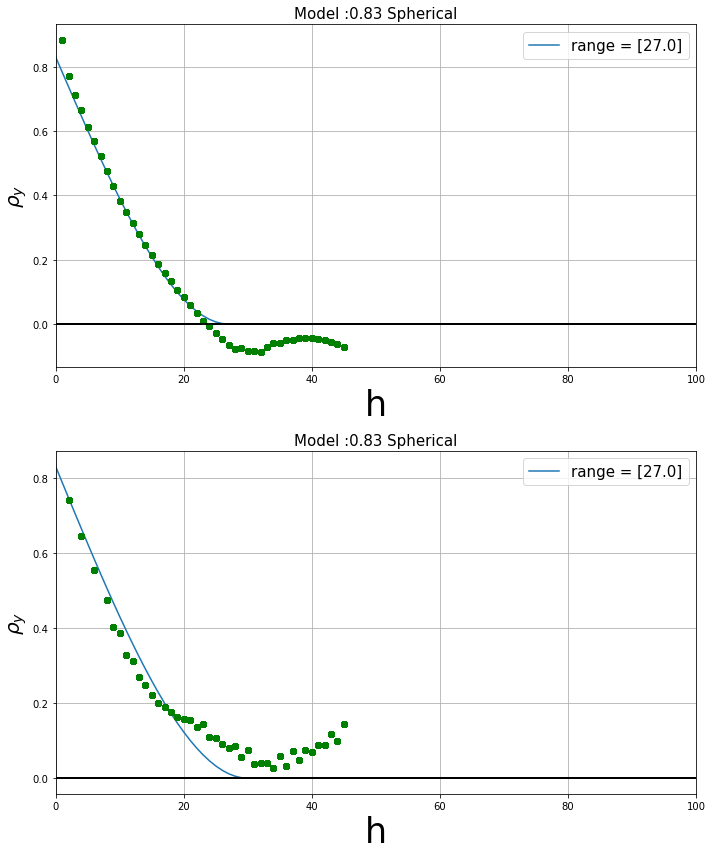

In [1217]:
varg_type = 2  # See Correlogram Functions
k = 0 # Permet de changer de direction
nstruct = dict_secondary["nstruct"]

MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien",
        4 : "Hole effect"}


label_dict = {0: dict_secondary["a_max"],
             1 : dict_secondary["a_min"]}

# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_secondary["cc"],dict_secondary["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 & len(dict_secondary["cc"]) >= 2 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_secondary["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_secondary["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1

fig, axes = plt.subplots(2,1, figsize=(10, 12))
cy = np.zeros(shape=(LENGTH + 1))

for s in range(2) :
    for h in range(0, LENGTH + 1):
        # Calcul Correlogram model Z
        cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h),varg_type, dict_secondary,nstruct)
        H[h] = h
        MM_vargs = [ cz_True,cy,czy ]

        # Label Display 
    for i in [1]:
        if s == 0 :
            LABEL =  "range = {}".format(dict_secondary["a_max"])
        axes[s].plot(H, MM_vargs[i], label=LABEL)
        var = locals()["varc_{}".format(i + 1)]

        # Calcul des valeurs de Correlogram à partir du variogram
    for h in range(1, LENGTH):
        H[h] = h
        axes[s].plot(
            var["Lag Distance"][var["Variogram Index"] == (s + 1)],
            Sill_vals[i]
            - var["Variogram Value"][var["Variogram Index"] == (s + 1)],
            "o",
            color=colors[i],
        )

        if nstruct == 1 :

            TITLE = "Model :" +str(dict_secondary["cc"][0])+ " " + str(MODEL_name[dict_secondary["vtype"][0]])
        else :
            TITLE = "Model :" +str(dict_secondary["cc"][0])+ " " + str(MODEL_name[dict_secondary["vtype"][0]]) + " + \n" +str(dict_secondary["cc"][1])+ " " + str(MODEL_name[dict_secondary["vtype"][1]])

        axes[s].set_ylabel(labels_2[i], size=20)
        axes[s].plot(H, ones, color="Black")
        axes[s].set_xlabel("h", size=35)
        axes[s].set_title(TITLE, size=15)
        axes[s].legend(loc="best", prop={"size": 15})
        axes[s].grid()
    plt.setp(axes, xlim=(0, 100))
    plt.tight_layout()

# Ici pas de direction précise, à inclure dans une loop le cas échéant
    varg_type = varg_type + 1
    k +=1

# Cross Model (ZY) 

### Minimize function  (Cross)

In [50]:
def optimize_RMSE_ZY_model(x, args):
    
    var = args[0][args[0]["Variogram Value"] != -999]
    var = var.dropna(axis = 0)
    Sill_value = args[1] # Variance des données
    RMSE = [] # Liste des valeurs RMSE
    Direction = ["Major","Minor"]
    
    ## x0
    if len(x0) == 3 :
        a_max_zy_0 = [x[0]]         # range
        a_min_zy_0 = [x[1]]
        cc_zy_0 = [args[2]]         # effet pépite
        MODEL_value = [args[3]]     # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches" 
        
        a_max_zy_0 = x[0::3]        # range
        a_min_zy_0 = x[1::3]
        cc_zy_0 = [args[2]]         # effet pépite
        MODEL_value = args[3::]     # type de modèle
        nstruct = len(MODEL_value)  # nombre de couche
    
    dict_cross_0 = {"a_max" : a_max_zy_0
                ,"a_min" : a_min_zy_0
                ,"cc" : cc_zy_0
                ,"vtype" : MODEL_value
                 }
    
    print(dict_cross_0)
    for i,Dir in enumerate(Direction) :
        k = 2+i
        c = [] # liste des covario  
        
        variogram_lag = var["Lag Distance"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value = Sill_value - var["Variogram Value"][var["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        lag_value = variogram_lag # valeurs des lags
        
        
        for h in lag_value:
            MODEL = C_ZY(np.matrix(h), np.matrix(h), k, dict_cross_0,nstruct)
            
            c.append(MODEL.tolist()[0][0]) # convertion np.matrix to float
        RMSE.append(np.sqrt(mean_squared_error(variogram_value,c)))
    #print("vario :", variogram_value.values)
    #print("c :", c)
    print("RMSE :",RMSE, "\n")
        
    return sum(RMSE)

In [1220]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

corr = np.corrcoef(Primary["Primary"], Primary["Secondary"])[0,1]
corr = float("{:.2f}".format(corr))
print("Coeff de correlation :", corr)

# Allocation des valeurs initiales

# range max, min, effet pepite, type de couche
a_max_zy_0  = np.array([50])
a_min_zy_0  = np.array([50])
cc_zy_0     = [corr]
MODEL_value = np.array([MODEL_type["Spherical"]])


var, Sill_value,= varc_3, corr # variogram , Variance
nstruct = len(a_max_zy_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])
args = np.append(args,[var,Sill_value])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_zy_0[i]
    b = a_min_zy_0[i]
    c = cc_zy_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b])
    args = np.append(args,[c,d])
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,300],[0,300]]
if nstruct > 1 :
    Bounds *=  len(a_max_zy_0)


# Minimize
ZY_model = minimize(optimize_RMSE_ZY_model,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(ZY_model)

a_max_zy = [float("{:.0f}".format(x)) for x in ZY_model.x[0::3]]
a_min_zy = [float("{:.0f}".format(x)) for x in ZY_model.x[1::3]]
cc_zy = [corr]

dict_cross = {"a_max" : a_max_zy
                ,"a_min" : a_min_zy
                ,"cc" : cc_zy
                ,"vtype" : MODEL_value
              ,"nstruct"  : nstruct
}

Coeff de correlation : -0.08
{'a_max': array([50.]), 'a_min': array([50.]), 'cc': [-0.08], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7252996058188814, 0.7252996058188814] 

{'a_max': array([49.99969723]), 'a_min': array([50.]), 'cc': [-0.08], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7252996713568558, 0.7252996058188814] 

{'a_max': array([50.00030277]), 'a_min': array([50.]), 'cc': [-0.08], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7252995402799396, 0.7252996058188814] 

{'a_max': array([50.]), 'a_min': array([49.99969723]), 'cc': [-0.08], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7252996058188814, 0.7252996713568558] 

{'a_max': array([50.]), 'a_min': array([50.00030277]), 'cc': [-0.08], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7252996058188814, 0.7252995402799396] 

{'a_max': array([50.00000043]), 'a_min': array([50.00000043]), 'cc': [-0.08], 'vtype': array([1.0], dtype=object)}
RMSE : [0.7252996057264215, 0.7252996057264215] 

{'a_max': array([49.99969765]

In [1221]:
dict_cross

{'a_max': [300.0],
 'a_min': [300.0],
 'cc': [-0.08],
 'vtype': array([1]),
 'nstruct': 1}

### Plot fitted Cross Correlogram

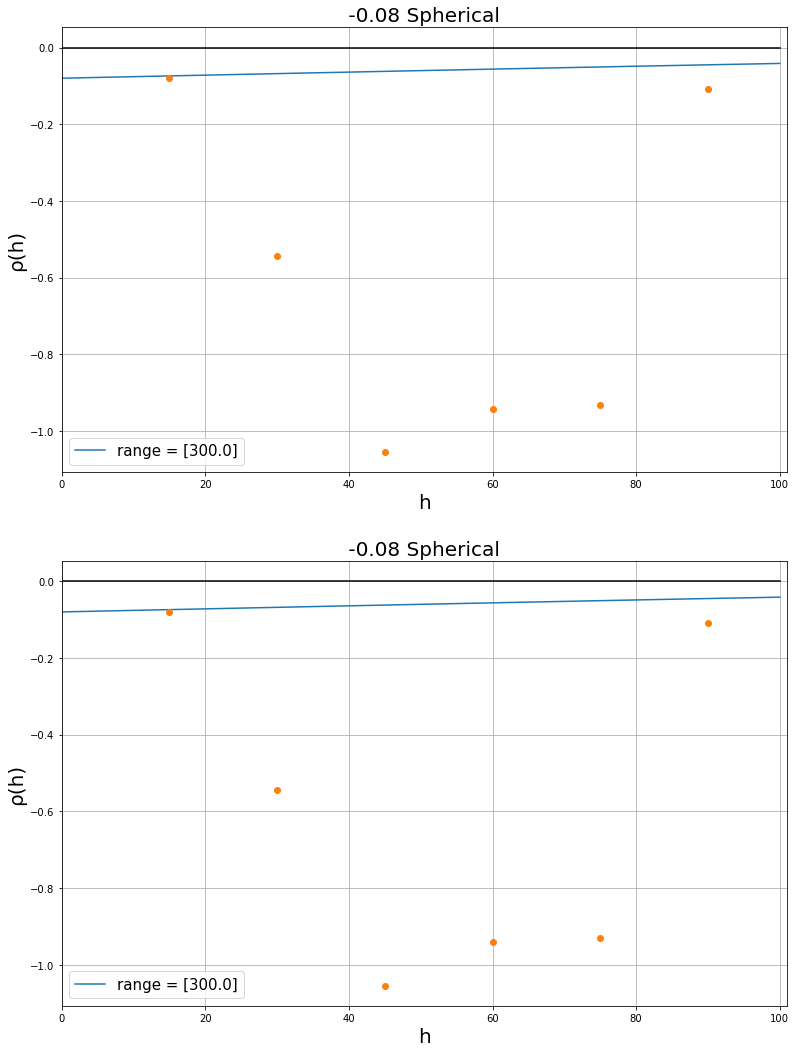

In [1222]:
## Constantes de démarrage
varg_type = 2  # See Correlogram Functions
MODEL_name ={ 1 : "Spherical",
         2 : "Exponential",
         3 : "Gaussien",
        4 : "Hole effect"}

label_dict = {0: dict_cross["a_max"],
             1 : dict_cross["a_min"]}

nstruct = dict_cross["nstruct"]
# Title name
TITLE = ""
count = 1
for cc,vtype in zip(dict_cross["cc"],dict_cross["vtype"]) :
    model = MODEL_name[vtype]
    if count == 1 & len(dict_cross["cc"]) >= 2 :
        TITLE += f"{cc} {model} +" 
    elif count == len(dict_cross["cc"]):
        TITLE += f" {cc} {model} "
    elif count == 1 & len(dict_cross["cc"]) == 1 :
        TITLE += f"{cc} {model}"                    
    else : 
        TITLE += f" {cc} {model} +"
    count += 1
    
fig, axes = plt.subplots(2, 1, figsize=(13, 18))
czy = np.zeros(shape=(LENGTH + 1))

for s in range(2) :
    
    for h in range(0, LENGTH + 1):
        czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross, nstruct)
        H[h] = h
    MM_vargs = [ cz_True,cy,czy ]

    for i in [2]: 
        LABEL =  "range = {}".format(label_dict[s])
        axes[s].plot(H, MM_vargs[i], label=LABEL)

        if (i + 1) <= 3:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (s + 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (s + 1)
                ],
                "o"
                )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, LENGTH + 1)
    #axes[s].set_ylim(-0.1, 1)
    axes[s].set_ylabel("\u03C1(h)", size=20)
    axes[s].set_xlabel("h", size=20)
    axes[s].set_title(TITLE,size=20)
    axes[s].legend(loc="best", prop={"size": 15})
    varg_type = varg_type + 1
    
Save = False 
if Save :
    fileout =  "C:/Users/Alexandre/Desktop/Cours/Stage/\collocatedcokriging/Correlogram_test/"+Model+".png"
    plt.tight_layout()
    plt.savefig('fileout', bbox_inches="tight", dpi=300)
    

## Set up MMII Correlogram

In MMII the secondary correlogram ρy(h) and the correlation are used to calculate the secondary covariance and the cross covariance. In MMII the primary covariance is fit using ρr(h) and the secondary correlogram ρy(h). The primary correlogram for the MMII is denoted as ρzMMII(h) in the images below. ρzMMII(h) should be similar to ρz(h)

#### Le modèle ρzMMII doit similaire à ρz(h) : On passe obligatoirement par une fonction de minimisation 

### Minimize function

In [53]:
def optimize_RMSE_scalling_correlogram(x, args):
    """
    On minimize ici la différence entre le correlogram généré C_Z_MII ( qui se base sur le correlogram Y) et
    le modèle de correlogram C_Z. Les modifications s'effectuent sur le correlogram C_r 
    """
    
    dict_secondary = args[0] # dictionnaire des valeurs du correlogram secondaire
    dict_primary   = args[1] # dictionnaire des valeurs du correlogram primaire
    corr  = args[2]
    RMSE = [] # Liste des RMSE
    
    Direction = ["Major", "Minor"] #Deux directions à additionner
    
    ## x0
    if len(x0) == 3 :
        a_max_r_0 = [x[0]]         # range
        a_min_r_0 = [x[1]]
        cc_r_0 = [x[2]]            # effet pépite
        MODEL_value = [args[3]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches", mais n'est pas forcément compatible.
        
        a_max_r_0 = x[0::3]        # range
        a_min_r_0 = x[1::3]
        cc_r_0 = x[2::3]           # effet pépite
        MODEL_value = args[3::]      # type de modèle
        nstruct = len(MODEL_value) # nombre de couche
    
    dict_scalling_0 = {"a_max" : a_max_r_0
                ,"a_min" : a_min_r_0
                ,"cc" : cc_r_0
                ,"vtype" : MODEL_value
                 }
    print(dict_scalling_0)
    for i,Dir in enumerate(Direction) :
        
        # Inititialisation des matrices
        cy = np.zeros(shape=(101))
        cr = np.zeros(shape=(101))
        cz_mm2 = np.zeros(shape=(101))
        cz = np.zeros(shape=(101))
        k = i + 2                # numéro de la direction 
        
        for h in range(0, 101):
            cy[h] = C_Y_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_secondary, nstruct = 1)

            cz[h] = C_Z_alternate(np.matrix(h), np.matrix(h),k,
                                  dict_primary, nstruct = 1)

            cr[h] = C_r(np.matrix(h), np.matrix(h), k,
                        dict_scalling_0,nstruct = 1 )

            cz_mm2[h] = C_Z_MM2(np.matrix(h), np.matrix(h), k, corr,dict_secondary, dict_scalling_0)

            RMSE.append(np.sqrt(mean_squared_error(cz,cz_mm2))) 
    return sum(RMSE)

In [1226]:
print('-' * 30)
print("dict_primary :", dict_primary)
print("dict_secondary :", dict_secondary)
print("dict_cross :", dict_cross)

------------------------------
dict_primary : {'a_max': [31.0], 'a_min': [31.0], 'cc': [2.0], 'vtype': array([1]), 'nstruct': 1}
dict_secondary : {'a_max': [27.0], 'a_min': [30.0], 'cc': [0.83], 'vtype': array([1]), 'nstruct': 1}
dict_cross : {'a_max': [300.0], 'a_min': [300.0], 'cc': [-0.08], 'vtype': array([1]), 'nstruct': 1}


In [1227]:
MODEL_type ={"Spherical" : 1,
        "Exponential" : 2,
        "Gaussien" : 3}

# Allocation des valeurs initiales
#x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

# range max, min, effet pepite, type de couche
a_max_r_0 = np.array([10])
a_min_r_0 = np.array([10])
cc_r_0    = np.array([2])
MODEL_value = np.array([MODEL_type["Spherical"]])
nstruct = len(a_max_r_0) # nstruct, nombre de couche

x0,args = np.empty(1),np.empty(1)
args = np.append(args,[dict_secondary,dict_primary,corr])

for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
    a = a_max_r_0[i]
    b = a_min_r_0[i]
    c = cc_r_0[i]
    d = MODEL_value[i]
    x0 = np.append(x0,[a,b,c])
    args = np.append(args,d)
x0 = np.delete(x0,0)
args = np.delete(args,0)



# Boundaries 
Bounds = [[0,150],[0,150],[0,5]]
if nstruct > 1 :
    Bounds *=  nstruct


# Minimize
scalling_model = minimize(optimize_RMSE_scalling_correlogram,x0,args = args,
                            method='TNC', jac = '3-point',
                            bounds = Bounds,tol = 1e-9)

print(scalling_model)

a_max_r = [float("{:.0f}".format(x)) for x in scalling_model.x[0::3]]
a_min_r = [float("{:.0f}".format(x)) for x in scalling_model.x[1::3]]
cc_r = [float("{:.2f}".format(x)) for x in scalling_model.x[2::3]]

dict_scalling = {"a_max" : a_max_r
                ,"a_min" : a_min_r
                ,"cc" : cc_r
                ,"vtype" : MODEL_value
}

{'a_max': [10.0], 'a_min': [10.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [9.999939445455476], 'a_min': [10.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.000060554544524], 'a_min': [10.0], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [9.999939445455476], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [10.000060554544524], 'cc': [2.0], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [10.0], 'cc': [1.9999878890910952], 'vtype': [1]}
{'a_max': [10.0], 'a_min': [10.0], 'cc': [2.0000121109089046], 'vtype': [1]}
{'a_max': [10.000002534400409], 'a_min': [10.00000253466294], 'cc': [2.000000017603281], 'vtype': [1]}
{'a_max': [9.999941979840537], 'a_min': [10.00000253466294], 'cc': [2.000000017603281], 'vtype': [1]}
{'a_max': [10.00006308896028], 'a_min': [10.00000253466294], 'cc': [2.000000017603281], 'vtype': [1]}
{'a_max': [10.000002534400409], 'a_min': [9.999941980103067], 'cc': [2.000000017603281], 'vtype': [1]}
{'a_max': [10.000002534400409], 'a_min': [10.000063089222813], 'cc': [2.

{'a_max': [31.566181137952874], 'a_min': [31.5755983364555], 'cc': [2.0231689647976485], 'vtype': [1]}
{'a_max': [31.566181137952874], 'a_min': [31.5755983364555], 'cc': [2.0231934673610543], 'vtype': [1]}
{'a_max': [31.798224758255373], 'a_min': [31.81175240869672], 'cc': [1.9492294318356023], 'vtype': [1]}
{'a_max': [31.79803220555368], 'a_min': [31.81175240869672], 'cc': [1.9492294318356023], 'vtype': [1]}
{'a_max': [31.798417310957063], 'a_min': [31.81175240869672], 'cc': [1.9492294318356023], 'vtype': [1]}
{'a_max': [31.798224758255373], 'a_min': [31.811559774078958], 'cc': [1.9492294318356023], 'vtype': [1]}
{'a_max': [31.798224758255373], 'a_min': [31.81194504331448], 'cc': [1.9492294318356023], 'vtype': [1]}
{'a_max': [31.798224758255373], 'a_min': [31.81175240869672], 'cc': [1.9492176283655605], 'vtype': [1]}
{'a_max': [31.798224758255373], 'a_min': [31.81175240869672], 'cc': [1.949241235305644], 'vtype': [1]}
{'a_max': [31.682202922382196], 'a_min': [31.69367534639855], 'cc':

{'a_max': [30.92952449177743], 'a_min': [30.703234641443714], 'cc': [2.01005837212672], 'vtype': [1]}
{'a_max': [30.92933720058477], 'a_min': [30.7030487194048], 'cc': [2.01005837212672], 'vtype': [1]}
{'a_max': [30.92933720058477], 'a_min': [30.703420563482627], 'cc': [2.01005837212672], 'vtype': [1]}
{'a_max': [30.92933720058477], 'a_min': [30.703234641443714], 'cc': [2.0100462003098007], 'vtype': [1]}
{'a_max': [30.92933720058477], 'a_min': [30.703234641443714], 'cc': [2.0100705439436393], 'vtype': [1]}
{'a_max': [31.022041900936273], 'a_min': [30.9128251779146], 'cc': [2.003583665486333], 'vtype': [1]}
{'a_max': [31.02185404837452], 'a_min': [30.9128251779146], 'cc': [2.003583665486333], 'vtype': [1]}
{'a_max': [31.022229753498024], 'a_min': [30.9128251779146], 'cc': [2.003583665486333], 'vtype': [1]}
{'a_max': [31.022041900936273], 'a_min': [30.91263798670974], 'cc': [2.003583665486333], 'vtype': [1]}
{'a_max': [31.022041900936273], 'a_min': [30.913012369119457], 'cc': [2.00358366

{'a_max': [31.00209424181501], 'a_min': [30.907789583287958], 'cc': [2.0089399012894518], 'vtype': [1]}
{'a_max': [31.00209424181501], 'a_min': [30.907789583287958], 'cc': [2.0089642315249225], 'vtype': [1]}
{'a_max': [30.99301296814751], 'a_min': [30.90663545718884], 'cc': [2.008777370176185], 'vtype': [1]}
{'a_max': [30.99282529136914], 'a_min': [30.90663545718884], 'cc': [2.008777370176185], 'vtype': [1]}
{'a_max': [30.99320064492588], 'a_min': [30.90663545718884], 'cc': [2.008777370176185], 'vtype': [1]}
{'a_max': [30.99301296814751], 'a_min': [30.906448303465552], 'cc': [2.008777370176185], 'vtype': [1]}
{'a_max': [30.99301296814751], 'a_min': [30.90682261091213], 'cc': [2.008777370176185], 'vtype': [1]}
{'a_max': [30.99301296814751], 'a_min': [30.90663545718884], 'cc': [2.008765206116315], 'vtype': [1]}
{'a_max': [30.99301296814751], 'a_min': [30.90663545718884], 'cc': [2.008789534236055], 'vtype': [1]}
{'a_max': [30.997553802057766], 'a_min': [30.907212545284573], 'cc': [2.00886

{'a_max': [30.999602983984555], 'a_min': [30.99425094894501], 'cc': [2.008574746535779], 'vtype': [1]}
{'a_max': [30.999415268437346], 'a_min': [30.9940632646701], 'cc': [2.008574746535779], 'vtype': [1]}
{'a_max': [30.999415268437346], 'a_min': [30.994438633219918], 'cc': [2.008574746535779], 'vtype': [1]}
{'a_max': [30.999415268437346], 'a_min': [30.99425094894501], 'cc': [2.008562583702887], 'vtype': [1]}
{'a_max': [30.999415268437346], 'a_min': [30.99425094894501], 'cc': [2.008586909368671], 'vtype': [1]}
{'a_max': [30.999415268794166], 'a_min': [30.994250949472573], 'cc': [2.008574746504821], 'vtype': [1]}
{'a_max': [30.999227553246957], 'a_min': [30.994250949472573], 'cc': [2.008574746504821], 'vtype': [1]}
{'a_max': [30.999602984341376], 'a_min': [30.994250949472573], 'cc': [2.008574746504821], 'vtype': [1]}
{'a_max': [30.999415268794166], 'a_min': [30.994063265197664], 'cc': [2.008574746504821], 'vtype': [1]}
{'a_max': [30.999415268794166], 'a_min': [30.99443863374748], 'cc': [

{'a_max': [31.01491983902583], 'a_min': [30.999113783919775], 'cc': [2.0073296427890575], 'vtype': [1]}
{'a_max': [31.01491983902583], 'a_min': [30.99892607133488], 'cc': [2.007317487495835], 'vtype': [1]}
{'a_max': [31.01491983902583], 'a_min': [30.99892607133488], 'cc': [2.00734179808228], 'vtype': [1]}
{'a_max': [31.012634712935537], 'a_min': [31.00502916824533], 'cc': [2.0074344745029578], 'vtype': [1]}
{'a_max': [31.012446917338583], 'a_min': [31.00502916824533], 'cc': [2.0074344745029578], 'vtype': [1]}
{'a_max': [31.01282250853249], 'a_min': [31.00502916824533], 'cc': [2.0074344745029578], 'vtype': [1]}
{'a_max': [31.012634712935537], 'a_min': [31.004841418703407], 'cc': [2.0074344745029578], 'vtype': [1]}
{'a_max': [31.012634712935537], 'a_min': [31.00521691778725], 'cc': [2.0074344745029578], 'vtype': [1]}
{'a_max': [31.012634712935537], 'a_min': [31.00502916824533], 'cc': [2.0074223185749314], 'vtype': [1]}
{'a_max': [31.012634712935537], 'a_min': [31.00502916824533], 'cc': [

{'a_max': [31.012487115174935], 'a_min': [31.00214812018836], 'cc': [2.007548862402359], 'vtype': [1]}
{'a_max': [31.012299320471755], 'a_min': [31.00214812018836], 'cc': [2.007548862402359], 'vtype': [1]}
{'a_max': [31.012674909878115], 'a_min': [31.00214812018836], 'cc': [2.007548862402359], 'vtype': [1]}
{'a_max': [31.012487115174935], 'a_min': [31.001960388092492], 'cc': [2.007548862402359], 'vtype': [1]}
{'a_max': [31.012487115174935], 'a_min': [31.002335852284226], 'cc': [2.007548862402359], 'vtype': [1]}
{'a_max': [31.012487115174935], 'a_min': [31.00214812018836], 'cc': [2.007536705781662], 'vtype': [1]}
{'a_max': [31.012487115174935], 'a_min': [31.00214812018836], 'cc': [2.0075610190230564], 'vtype': [1]}
{'a_max': [31.0124703766769], 'a_min': [31.003236918207072], 'cc': [2.0075533888558663], 'vtype': [1]}
{'a_max': [31.01228258207508], 'a_min': [31.003236918207072], 'cc': [2.0075533888558663], 'vtype': [1]}
{'a_max': [31.012658171278723], 'a_min': [31.003236918207072], 'cc': 

{'a_max': [31.0109387665906], 'a_min': [31.00280438171843], 'cc': [2.007542280700129], 'vtype': [1]}
{'a_max': [31.0109387665906], 'a_min': [31.00261664678542], 'cc': [2.007530124119287], 'vtype': [1]}
{'a_max': [31.0109387665906], 'a_min': [31.00261664678542], 'cc': [2.007554437280971], 'vtype': [1]}
{'a_max': [31.010941308978865], 'a_min': [31.00261688277609], 'cc': [2.0075423443325677], 'vtype': [1]}
{'a_max': [31.010753523636243], 'a_min': [31.00261688277609], 'cc': [2.0075423443325677], 'vtype': [1]}
{'a_max': [31.011129094321486], 'a_min': [31.00261688277609], 'cc': [2.0075423443325677], 'vtype': [1]}
{'a_max': [31.010941308978865], 'a_min': [31.00242914784165], 'cc': [2.0075423443325677], 'vtype': [1]}
{'a_max': [31.010941308978865], 'a_min': [31.002804617710527], 'cc': [2.0075423443325677], 'vtype': [1]}
{'a_max': [31.010941308978865], 'a_min': [31.00261688277609], 'cc': [2.0075301877513403], 'vtype': [1]}
{'a_max': [31.010941308978865], 'a_min': [31.00261688277609], 'cc': [2.0

{'a_max': [31.010751009078536], 'a_min': [31.002616649367305], 'cc': [2.007542281396308], 'vtype': [1]}
{'a_max': [31.011126579733325], 'a_min': [31.002616649367305], 'cc': [2.007542281396308], 'vtype': [1]}
{'a_max': [31.01093879440593], 'a_min': [31.00242891443428], 'cc': [2.007542281396308], 'vtype': [1]}
{'a_max': [31.01093879440593], 'a_min': [31.00280438430033], 'cc': [2.007542281396308], 'vtype': [1]}
{'a_max': [31.01093879440593], 'a_min': [31.002616649367305], 'cc': [2.0075301248154616], 'vtype': [1]}
{'a_max': [31.01093879440593], 'a_min': [31.002616649367305], 'cc': [2.0075544379771544], 'vtype': [1]}
{'a_max': [31.010938780498265], 'a_min': [31.002616648076362], 'cc': [2.0075422810482184], 'vtype': [1]}
{'a_max': [31.01075099517095], 'a_min': [31.002616648076362], 'cc': [2.0075422810482184], 'vtype': [1]}
{'a_max': [31.011126565825577], 'a_min': [31.002616648076362], 'cc': [2.0075422810482184], 'vtype': [1]}
{'a_max': [31.010938780498265], 'a_min': [31.002428913143344], 'cc

In [1228]:
Sill_vals

[1.0, 1.0, -0.08]

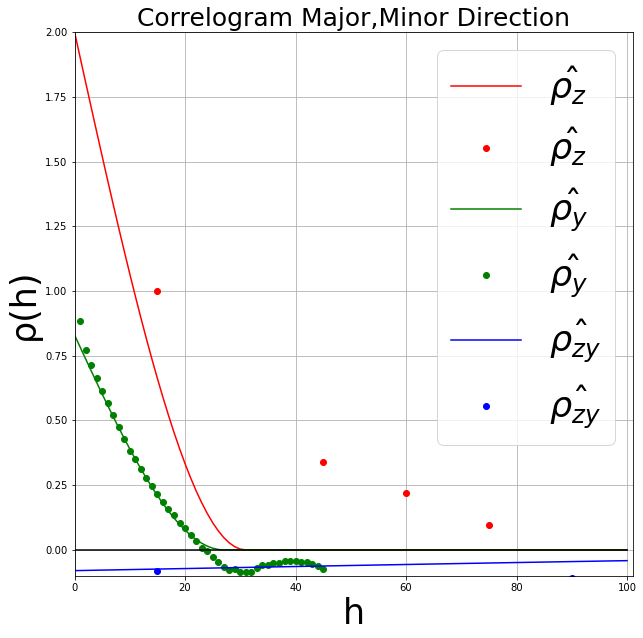

In [1229]:
condition = True 
if condition :
    varg_type = 2  # See Correlogram Functions
    k = 0

    for Dir in ["Major,Minor"]:
        for h in range(0, 101):

            cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,dict_secondary, nstruct = 1)

            cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,dict_primary, nstruct = 1)

            cz[h] = C_Z_MM2(np.matrix(h), np.matrix(h), varg_type, corr,dict_secondary,dict_scalling )

            cr[h] = C_r (np.matrix(h), np.matrix(h), varg_type, dict_scalling,nstruct = 1 )
            
            czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross, 1)
            
            H[h] = h
        MM_vargs = [cz_True, cy, czy]
        fig, axes = plt.subplots(1, 1, figsize=(10, 10))
        for i in range(0, 3):
            axes.plot(H, MM_vargs[i], color=colors[i], label=labels_1[i])
            if (i + 1) < 4:
                var = locals()["varc_{}".format(i + 1)]
                axes.plot(
                    var["Lag Distance"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    Sill_vals[i]
                    - var["Variogram Value"][
                        var["Variogram Index"] == (varg_type - 1)
                    ],
                    "o",
                    color=colors[i],
                    label=labels_1[i],
                )

        axes.plot(H, ones, color="Black")
        axes.grid()
        plt.xlim(0, 101)
        plt.ylim(-0.1, 2)
        plt.ylabel("\u03C1(h)", size=35)
        plt.xlabel("h", size=35)
        plt.title(
            "Correlogram {} Direction".format(Dir),
            size=25,
        )
        axes.legend(loc="best", prop={"size": 35})
        plt.savefig("MM1_MM2_var_{}".format(Dir), bbox_inches="tight", dpi=300)
        varg_type = varg_type + 1

# LMC 

In [54]:
def optimize_RMSE_LMC_model(x, args):
    """
    args : args[0] correspond au DataFrame ; args[1] correspond à la Sill_value (= 1)
    gamma= b*second(a_min,a_max)+ c*first(a_min_g,a_max_g)
    On cherche à minimiser un seul modèle qui serait compatible avec les trois autres correlogrammes (pas les modèles) 
    """
    
    df_primary   = args[0] # DataFrame des valeurs primaire
    df_secondary = args[1] # DataFrame des valeurs secondaire
    df_cross     = args[2] # DataFrame des valeurs cross 
    sill_value_z = args[3]
    sill_value_y = args[4]
    corr         = args[5]
    nstruct      = args[-1]
    RMSE = [] # Liste des RMSE
    Direction = ["Major", "Minor"] #Deux directions 
    ## x0
    if nstruct == 1 : # modèle à une couche
        a_max_0 = [x[0]]         # range
        a_min_0 = [x[1]]
        cc_0 = x[2::]            # effet pépite
        MODEL_value = [args[6]]  # type de modèle
        nstruct = 1
        
    else : # modèle plus complexe à plusieurs "couches", mais n'est pas forcément compatible avec les données.
    
        a_max_0 = x[0:-3*nstruct:nstruct]     # range
        a_min_0 = x[1:-3*nstruct:nstruct]
        cc_0 = x[nstruct*nstruct::]   # effet pépite
        MODEL_value = args[6:6+nstruct]      # type de modèle
        
        ## Condition des sills, il faut c1 + c2 + .. = sill_value du correlogram
        for i,sill in zip([0,1,2],[sill_value_z,sill_value_y,corr]) :
            for c1,c2 in [cc_0[i::3]] :
                if c1 + c2 > sill :
                    cc_0[i+3] = sill - cc_0[i]
                    print(cc_0[i],cc_0[i+3])

    dict_model_LMC_z = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[0::3]
                ,"vtype" : MODEL_value
                 }
    
    dict_model_LMC_y = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[1::3]
                ,"vtype" : MODEL_value
                 }
    
    dict_model_LMC_zy = {"a_max" : a_max_0
                ,"a_min" : a_min_0
                ,"cc" : cc_0[2::3]
                ,"vtype" : MODEL_value
                 }
    
    print("Z : ",dict_model_LMC_z,'\n Y :',dict_model_LMC_y,'\n ZY :',dict_model_LMC_zy)
    for i,Dir in enumerate(Direction) :
        k = i + 2
        MODEL_y  = []
        MODEL_z  = []
        MODEL_zy = []
        
        ### Correlogramme Y
        lag_value_y = df_secondary["Lag Distance"][df_secondary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_y = sill_value_y - df_secondary["Variogram Value"][df_secondary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        
        for h in lag_value_y:
            MODEL = C_Y_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_y,nstruct)
            MODEL_y.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_y,MODEL_y)))
        
        ### Correlogramme Z
        lag_value_z = df_primary["Lag Distance"][df_primary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_z = sill_value_z - df_primary["Variogram Value"][df_primary["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        for h in lag_value_z:
            MODEL = C_Z_alternate(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_z,nstruct)
            MODEL_z.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_z,MODEL_z)))
        
        ## Correlogramme ZY
        lag_value_zy = df_cross["Lag Distance"][df_cross["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        variogram_value_zy = corr - df_cross["Variogram Value"][df_cross["Variogram Index"] == float(i+1)] # 1.0 Major / 2.0 Minor
        for h in lag_value_zy:
            MODEL = C_ZY(np.matrix(h), np.matrix(h), k,
                                  dict_model_LMC_zy,nstruct)
            
            MODEL_zy.append(MODEL.tolist()[0][0])
        RMSE.append(np.sqrt(mean_squared_error(variogram_value_zy,MODEL_zy)))
    #print("RMSE value :",RMSE , " sum(RMSE) :",sum(RMSE),
    print("\n", "-" * 45)
    return sum(RMSE)

In [1231]:
condition = True
if condition :
    MODEL_type ={"Spherical" : 1,
            "Exponential" : 2,
            "Gaussien" : 3}

    # Allocation des valeurs initiales
    #x0 = np.array([a_max_z_0,a_min_z_0, cc_z_0,MODEL_value])

    # range max, min, effet pepite, type de couche
    a_max_LMC_0  = np.array([40])
    a_min_LMC_0  = np.array([40])
    cc_LMC_0     = np.array([0.6,0.4,corr]) # les cc sont en fin de liste
    sill_value_z = Sill_vals[0]
    sill_value_y = Sill_vals[1]
    sill_value_zy = Sill_vals[2]

    MODEL_value = np.array([MODEL_type["Spherical"]]  )
    nstruct = len(a_max_LMC_0) # nstruct, nombre de couche

    x0,args = np.empty(1),np.empty(1)
    args = np.append(args,[varc_1.dropna(axis = 0),varc_2.dropna(axis = 0),varc_3.dropna(axis = 0),sill_value_z,sill_value_y,sill_value_zy])

    for i in np.arange(nstruct) : # permet de minimiser un modèle à plusieur couche   
        a = a_max_LMC_0[i]
        b = a_min_LMC_0[i]
        d = MODEL_value[i]
        x0 = np.append(x0,[a,b])
        args = np.append(args,[d])
    args = np.append(args,nstruct)
    c = cc_LMC_0.tolist()
    x0 = np.append(x0,c)
    x0 = np.delete(x0,0)
    args = np.delete(args,0)


    # Boundaries 
    Bounds = [[0,100],[0,100]] * nstruct
    Bounds +=  [[0.1,1],[0.1,1],[-0.5,corr]] * nstruct

    # Minimize
    LMC_model = minimize(optimize_RMSE_LMC_model,x0,args = args,
                                method='TNC', jac = '3-point',
                                bounds = Bounds,options = {"xtol" : 1e-10,"ftol" : 1e-10,
                                                          "disp" : True})




Z :  {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [40.0], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [40.0], 'a_min': [40.0], 'cc': array([-0.08]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [39.999757781821906], 'a_min': [40.0], 'cc': array([-0.08]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [40.000242218178094], 'a_min': [40.0], 'cc': array([-0.08]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [40.0], 'a_min': [39.999757781821906], 'cc': array([0.6]), 'vtype': [1]} 
 Y


 ---------------------------------------------
Z :  {'a_max': [39.999999536285806], 'a_min': [39.9999996687698], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [39.999999536285806], 'a_min': [39.9999996687698], 'cc': array([0.39999395]), 'vtype': [1]} 
 ZY : {'a_max': [39.999999536285806], 'a_min': [39.9999996687698], 'cc': array([-0.08]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [39.999999536285806], 'a_min': [39.9999996687698], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [39.999999536285806], 'a_min': [39.9999996687698], 'cc': array([0.40000606]), 'vtype': [1]} 
 ZY : {'a_max': [39.999999536285806], 'a_min': [39.9999996687698], 'cc': array([-0.08]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [39.999999536285806], 'a_min': [39.9999996687698], 'cc': array([0.6]), 'vtype': [1]} 
 Y : {'a_max': [39.999999536285806], 'a_min': [39.9999996687698], 'cc': array([0.4]), 'vtype': [1]} 
 ZY : {'a_max': [39.9999995362


 ---------------------------------------------
Z :  {'a_max': [26.080424827858252], 'a_min': [38.063665891971354], 'cc': array([0.65622042]), 'vtype': [1]} 
 Y : {'a_max': [26.080424827858252], 'a_min': [38.063665891971354], 'cc': array([0.7]), 'vtype': [1]} 
 ZY : {'a_max': [26.080424827858252], 'a_min': [38.063665891971354], 'cc': array([-0.08303572]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [26.080266899033607], 'a_min': [38.063665891971354], 'cc': array([0.65622042]), 'vtype': [1]} 
 Y : {'a_max': [26.080266899033607], 'a_min': [38.063665891971354], 'cc': array([0.7]), 'vtype': [1]} 
 ZY : {'a_max': [26.080266899033607], 'a_min': [38.063665891971354], 'cc': array([-0.08303572]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [26.080582756682897], 'a_min': [38.063665891971354], 'cc': array([0.65622042]), 'vtype': [1]} 
 Y : {'a_max': [26.080582756682897], 'a_min': [38.063665891971354], 'cc': array([0.7]), 'vtype': [

 ---------------------------------------------
Z :  {'a_max': [29.18954495321312], 'a_min': [28.092235088207662], 'cc': array([0.70905041]), 'vtype': [1]} 
 Y : {'a_max': [29.18954495321312], 'a_min': [28.092235088207662], 'cc': array([0.84158123]), 'vtype': [1]} 
 ZY : {'a_max': [29.18954495321312], 'a_min': [28.092235088207662], 'cc': array([-0.08466693]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.18954495321312], 'a_min': [28.092235088207662], 'cc': array([0.70906252]), 'vtype': [1]} 
 Y : {'a_max': [29.18954495321312], 'a_min': [28.092235088207662], 'cc': array([0.84158123]), 'vtype': [1]} 
 ZY : {'a_max': [29.18954495321312], 'a_min': [28.092235088207662], 'cc': array([-0.08466693]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.18954495321312], 'a_min': [28.092235088207662], 'cc': array([0.70905646]), 'vtype': [1]} 
 Y : {'a_max': [29.18954495321312], 'a_min': [28.092235088207662], 'cc': array([0.84157517])

 ZY : {'a_max': [28.412264966702327], 'a_min': [30.585278164349123], 'cc': array([-0.08425912]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [28.412264966702327], 'a_min': [30.585092957711797], 'cc': array([0.6958414]), 'vtype': [1]} 
 Y : {'a_max': [28.412264966702327], 'a_min': [30.585092957711797], 'cc': array([0.80618592]), 'vtype': [1]} 
 ZY : {'a_max': [28.412264966702327], 'a_min': [30.585092957711797], 'cc': array([-0.08425912]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [28.412264966702327], 'a_min': [30.585092957711797], 'cc': array([0.69585351]), 'vtype': [1]} 
 Y : {'a_max': [28.412264966702327], 'a_min': [30.585092957711797], 'cc': array([0.80618592]), 'vtype': [1]} 
 ZY : {'a_max': [28.412264966702327], 'a_min': [30.585092957711797], 'cc': array([-0.08425912]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [28.412264966702327], 'a_min': [30.585092957711797], 'cc': array([0.6

 ---------------------------------------------
Z :  {'a_max': [28.109496799279587], 'a_min': [31.33266699626949], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [28.109496799279587], 'a_min': [31.33266699626949], 'cc': array([0.80836141]), 'vtype': [1]} 
 ZY : {'a_max': [28.109496799279587], 'a_min': [31.33266699626949], 'cc': array([-0.08892315]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [28.109326584532766], 'a_min': [31.332477262731622], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [28.109326584532766], 'a_min': [31.332477262731622], 'cc': array([0.80836141]), 'vtype': [1]} 
 ZY : {'a_max': [28.109326584532766], 'a_min': [31.332477262731622], 'cc': array([-0.08892315]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [28.109326584532766], 'a_min': [31.33285672980736], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [28.109326584532766], 'a_min': [31.33285672980736], 'cc': array([0.80836141]), 'vtype': [1]} 
 ZY 

 ---------------------------------------------
Z :  {'a_max': [29.070651380791944], 'a_min': [31.758824802496605], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.070651380791944], 'a_min': [31.758824802496605], 'cc': array([0.79618279]), 'vtype': [1]} 
 ZY : {'a_max': [29.070651380791944], 'a_min': [31.758824802496605], 'cc': array([-0.09000271]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.070651380791944], 'a_min': [31.759209433059823], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.070651380791944], 'a_min': [31.759209433059823], 'cc': array([0.79618279]), 'vtype': [1]} 
 ZY : {'a_max': [29.070651380791944], 'a_min': [31.759209433059823], 'cc': array([-0.09000271]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.070651380791944], 'a_min': [31.759017117778214], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [29.070651380791944], 'a_min': [31.759017117778214], 'cc': array([0.79618279]), 'vtype

 ---------------------------------------------
Z :  {'a_max': [29.07065149763114], 'a_min': [31.759209437346794], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.07065149763114], 'a_min': [31.759209437346794], 'cc': array([0.79618279]), 'vtype': [1]} 
 ZY : {'a_max': [29.07065149763114], 'a_min': [31.759209437346794], 'cc': array([-0.09000271]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.07065149763114], 'a_min': [31.75901712206516], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [29.07065149763114], 'a_min': [31.75901712206516], 'cc': array([0.79618279]), 'vtype': [1]} 
 ZY : {'a_max': [29.07065149763114], 'a_min': [31.75901712206516], 'cc': array([-0.09000271]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.07065149763114], 'a_min': [31.75901712206516], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [29.07065149763114], 'a_min': [31.75901712206516], 'cc': array([0.79618279]), 'vtype': [1


 ---------------------------------------------
Z :  {'a_max': [29.23465282421791], 'a_min': [31.761813388252946], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.23465282421791], 'a_min': [31.761813388252946], 'cc': array([0.79364361]), 'vtype': [1]} 
 ZY : {'a_max': [29.23465282421791], 'a_min': [31.761813388252946], 'cc': array([-0.09101101]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.23465282421791], 'a_min': [31.761813388252946], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.23465282421791], 'a_min': [31.761813388252946], 'cc': array([0.79364361]), 'vtype': [1]} 
 ZY : {'a_max': [29.23465282421791], 'a_min': [31.761813388252946], 'cc': array([-0.0909989]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.234652813831136], 'a_min': [31.761813356777644], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.234652813831136], 'a_min': [31.761813356777644], 'cc': array([0.79364361]), 'vtype': [1]} 
 ZY :

 ZY : {'a_max': [29.269417298094265], 'a_min': [31.884805670009186], 'cc': array([-0.23065111]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.269417298094265], 'a_min': [31.884805670009186], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.269417298094265], 'a_min': [31.884805670009186], 'cc': array([0.79332898]), 'vtype': [1]} 
 ZY : {'a_max': [29.269417298094265], 'a_min': [31.884805670009186], 'cc': array([-0.230639]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.26941729699734], 'a_min': [31.884805669238624], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.26941729699734], 'a_min': [31.884805669238624], 'cc': array([0.79332898]), 'vtype': [1]} 
 ZY : {'a_max': [29.26941729699734], 'a_min': [31.884805669238624], 'cc': array([-0.23064505]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.26924005737405], 'a_min': [31.884805669238624], 'cc': array([1.]), 'vtype': [1]} 
 Y 

 ---------------------------------------------
Z :  {'a_max': [29.03258746919854], 'a_min': [31.748981369167208], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [29.03258746919854], 'a_min': [31.748981369167208], 'cc': array([0.79248108]), 'vtype': [1]} 
 ZY : {'a_max': [29.03258746919854], 'a_min': [31.748981369167208], 'cc': array([-0.37592218]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.03258746919854], 'a_min': [31.748981369167208], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [29.03258746919854], 'a_min': [31.748981369167208], 'cc': array([0.79248108]), 'vtype': [1]} 
 ZY : {'a_max': [29.03258746919854], 'a_min': [31.748981369167208], 'cc': array([-0.37592218]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.03258746919854], 'a_min': [31.748981369167208], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.03258746919854], 'a_min': [31.748981369167208], 'cc': array([0.79247503]), 'vtype


 ---------------------------------------------
Z :  {'a_max': [29.210209840870334], 'a_min': [31.850849594798692], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.210209840870334], 'a_min': [31.850849594798692], 'cc': array([0.79312306]), 'vtype': [1]} 
 ZY : {'a_max': [29.210209840870334], 'a_min': [31.850849594798692], 'cc': array([-0.26696433]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.210209840870334], 'a_min': [31.850849594798692], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.210209840870334], 'a_min': [31.850849594798692], 'cc': array([0.793117]), 'vtype': [1]} 
 ZY : {'a_max': [29.210209840870334], 'a_min': [31.850849594798692], 'cc': array([-0.26697039]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.210209840870334], 'a_min': [31.850849594798692], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.210209840870334], 'a_min': [31.850849594798692], 'cc': array([0.793117]), 'vtype': [1]} 
 Z


 ---------------------------------------------
Z :  {'a_max': [29.225011705176314], 'a_min': [31.859338613601317], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.225011705176314], 'a_min': [31.859338613601317], 'cc': array([0.79317]), 'vtype': [1]} 
 ZY : {'a_max': [29.225011705176314], 'a_min': [31.859338613601317], 'cc': array([-0.25787846]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.225011705387256], 'a_min': [31.859338613487743], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.225011705387256], 'a_min': [31.859338613487743], 'cc': array([0.79317]), 'vtype': [1]} 
 ZY : {'a_max': [29.225011705387256], 'a_min': [31.859338613487743], 'cc': array([-0.25788451]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.224834734660003], 'a_min': [31.859338613487743], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.224834734660003], 'a_min': [31.859338613487743], 'cc': array([0.79317]), 'vtype': [1]} 
 ZY : {


 ---------------------------------------------
Z :  {'a_max': [29.227914849395436], 'a_min': [31.855840121981675], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.227914849395436], 'a_min': [31.855840121981675], 'cc': array([0.79347498]), 'vtype': [1]} 
 ZY : {'a_max': [29.227914849395436], 'a_min': [31.855840121981675], 'cc': array([-0.26015882]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.227914849395436], 'a_min': [31.855840121981675], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.227914849395436], 'a_min': [31.855840121981675], 'cc': array([0.79347498]), 'vtype': [1]} 
 ZY : {'a_max': [29.227914849395436], 'a_min': [31.855840121981675], 'cc': array([-0.26014671]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.24243057049104], 'a_min': [31.838347663883475], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.24243057049104], 'a_min': [31.838347663883475], 'cc': array([0.7949999]), 'vtype': [1]} 
 


 ---------------------------------------------
Z :  {'a_max': [29.231543779669337], 'a_min': [31.851467007457124], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.231543779669337], 'a_min': [31.851467007457124], 'cc': array([0.79385621]), 'vtype': [1]} 
 ZY : {'a_max': [29.231543779669337], 'a_min': [31.851467007457124], 'cc': array([-0.26298808]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.231366769387407], 'a_min': [31.851467007457124], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.231366769387407], 'a_min': [31.851467007457124], 'cc': array([0.79385621]), 'vtype': [1]} 
 ZY : {'a_max': [29.231366769387407], 'a_min': [31.851467007457124], 'cc': array([-0.26298808]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.231720789951268], 'a_min': [31.851467007457124], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.231720789951268], 'a_min': [31.851467007457124], 'cc': array([0.79385621]), 'vtype': [1]}


 ---------------------------------------------
Z :  {'a_max': [29.229729314518355], 'a_min': [31.853653564651058], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.229729314518355], 'a_min': [31.853653564651058], 'cc': array([0.79367165]), 'vtype': [1]} 
 ZY : {'a_max': [29.229729314518355], 'a_min': [31.853653564651058], 'cc': array([-0.26157042]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.229729314518355], 'a_min': [31.853653564651058], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.229729314518355], 'a_min': [31.853653564651058], 'cc': array([0.7936656]), 'vtype': [1]} 
 ZY : {'a_max': [29.229729314518355], 'a_min': [31.853653564651058], 'cc': array([-0.26157647]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.229729314518355], 'a_min': [31.853653564651058], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.229729314518355], 'a_min': [31.853653564651058], 'cc': array([0.7936656]), 'vtype': [1]} 



 ---------------------------------------------
Z :  {'a_max': [29.226417564642368], 'a_min': [31.844429024756774], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.226417564642368], 'a_min': [31.844429024756774], 'cc': array([0.79367033]), 'vtype': [1]} 
 ZY : {'a_max': [29.226417564642368], 'a_min': [31.844429024756774], 'cc': array([-0.26114505]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.226417564642368], 'a_min': [31.844429024756774], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.226417564642368], 'a_min': [31.844429024756774], 'cc': array([0.79368244]), 'vtype': [1]} 
 ZY : {'a_max': [29.226417564642368], 'a_min': [31.844429024756774], 'cc': array([-0.26114505]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.226417564642368], 'a_min': [31.844429024756774], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.226417564642368], 'a_min': [31.844429024756774], 'cc': array([0.79367639]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.21872884314968], 'a_min': [31.83992718495987], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.21872884314968], 'a_min': [31.83992718495987], 'cc': array([0.79389089]), 'vtype': [1]} 
 ZY : {'a_max': [29.21872884314968], 'a_min': [31.83992718495987], 'cc': array([-0.26114047]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.219082710655844], 'a_min': [31.83992718495987], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.219082710655844], 'a_min': [31.83992718495987], 'cc': array([0.79389089]), 'vtype': [1]} 
 ZY : {'a_max': [29.219082710655844], 'a_min': [31.83992718495987], 'cc': array([-0.26114047]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.218905776902762], 'a_min': [31.839734379731034], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.218905776902762], 'a_min': [31.839734379731034], 'cc': array([0.79389089]), 'vtype': [1]} 
 ZY : {'

 ---------------------------------------------
Z :  {'a_max': [29.219082810237367], 'a_min': [31.83992718495987], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.219082810237367], 'a_min': [31.83992718495987], 'cc': array([0.79389089]), 'vtype': [1]} 
 ZY : {'a_max': [29.219082810237367], 'a_min': [31.83992718495987], 'cc': array([-0.26113958]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.218905876483685], 'a_min': [31.839734379731034], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.218905876483685], 'a_min': [31.839734379731034], 'cc': array([0.79389089]), 'vtype': [1]} 
 ZY : {'a_max': [29.218905876483685], 'a_min': [31.839734379731034], 'cc': array([-0.26113958]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.218905876483685], 'a_min': [31.840119990188704], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.218905876483685], 'a_min': [31.840119990188704], 'cc': array([0.79389089]), 'vtype': [1]} 
 Z


 ---------------------------------------------
Z :  {'a_max': [29.2265692729533], 'a_min': [31.834677895045225], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [29.2265692729533], 'a_min': [31.834677895045225], 'cc': array([0.79367569]), 'vtype': [1]} 
 ZY : {'a_max': [29.2265692729533], 'a_min': [31.834677895045225], 'cc': array([-0.19402179]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.2265692729533], 'a_min': [31.834677895045225], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.2265692729533], 'a_min': [31.834677895045225], 'cc': array([0.79366964]), 'vtype': [1]} 
 ZY : {'a_max': [29.2265692729533], 'a_min': [31.834677895045225], 'cc': array([-0.19402179]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.2265692729533], 'a_min': [31.834677895045225], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.2265692729533], 'a_min': [31.834677895045225], 'cc': array([0.79368175]), 'vtype': [1]} 
 ZY : 


 ---------------------------------------------
Z :  {'a_max': [29.219686774355253], 'a_min': [31.83927102372054], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.219686774355253], 'a_min': [31.83927102372054], 'cc': array([0.79386399]), 'vtype': [1]} 
 ZY : {'a_max': [29.219686774355253], 'a_min': [31.83927102372054], 'cc': array([-0.25275064]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.220040653462902], 'a_min': [31.83927102372054], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.220040653462902], 'a_min': [31.83927102372054], 'cc': array([0.79386399]), 'vtype': [1]} 
 ZY : {'a_max': [29.220040653462902], 'a_min': [31.83927102372054], 'cc': array([-0.25275064]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.219863713909078], 'a_min': [31.83907822246506], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.219863713909078], 'a_min': [31.83907822246506], 'cc': array([0.79386399]), 'vtype': [1]} 
 ZY : 

 ---------------------------------------------
Z :  {'a_max': [29.219025519028552], 'a_min': [31.840037969537118], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.219025519028552], 'a_min': [31.840037969537118], 'cc': array([0.79388753]), 'vtype': [1]} 
 ZY : {'a_max': [29.219025519028552], 'a_min': [31.840037969537118], 'cc': array([-0.26009174]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.219025519028552], 'a_min': [31.839845164804952], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [29.219025519028552], 'a_min': [31.839845164804952], 'cc': array([0.79388753]), 'vtype': [1]} 
 ZY : {'a_max': [29.219025519028552], 'a_min': [31.839845164804952], 'cc': array([-0.26009174]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.219025519028552], 'a_min': [31.839845164804952], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [29.219025519028552], 'a_min': [31.839845164804952], 'cc': array([0.79388753])

 Y : {'a_max': [29.219030512145494], 'a_min': [31.840037637994982], 'cc': array([0.7938876]), 'vtype': [1]} 
 ZY : {'a_max': [29.219030512145494], 'a_min': [31.840037637994982], 'cc': array([-0.2600924]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.219030512145494], 'a_min': [31.839844833264824], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [29.219030512145494], 'a_min': [31.839844833264824], 'cc': array([0.7938876]), 'vtype': [1]} 
 ZY : {'a_max': [29.219030512145494], 'a_min': [31.839844833264824], 'cc': array([-0.2600924]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.219030512145494], 'a_min': [31.839844833264824], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [29.219030512145494], 'a_min': [31.839844833264824], 'cc': array([0.7938876]), 'vtype': [1]} 
 ZY : {'a_max': [29.219030512145494], 'a_min': [31.839844833264824], 'cc': array([-0.2600924]), 'vtype': [1]}

 -------------------------

 ---------------------------------------------
Z :  {'a_max': [29.21967961734799], 'a_min': [31.839801733048205], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.21967961734799], 'a_min': [31.839801733048205], 'cc': array([0.79390206]), 'vtype': [1]} 
 ZY : {'a_max': [29.21967961734799], 'a_min': [31.839801733048205], 'cc': array([-0.26017721]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.21967961734799], 'a_min': [31.839801733048205], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.21967961734799], 'a_min': [31.839801733048205], 'cc': array([0.79389601]), 'vtype': [1]} 
 ZY : {'a_max': [29.21967961734799], 'a_min': [31.839801733048205], 'cc': array([-0.26018326]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.21967961734799], 'a_min': [31.839801733048205], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.21967961734799], 'a_min': [31.839801733048205], 'cc': array([0.79389601]), 'vtype': [1]} 
 ZY : {

 ---------------------------------------------
Z :  {'a_max': [29.219289530086872], 'a_min': [31.840020439246707], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.219289530086872], 'a_min': [31.840020439246707], 'cc': array([0.79389095]), 'vtype': [1]} 
 ZY : {'a_max': [29.219289530086872], 'a_min': [31.840020439246707], 'cc': array([-0.26012624]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.219289530086872], 'a_min': [31.839827634620693], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [29.219289530086872], 'a_min': [31.839827634620693], 'cc': array([0.79389095]), 'vtype': [1]} 
 ZY : {'a_max': [29.219289530086872], 'a_min': [31.839827634620693], 'cc': array([-0.26012624]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.219289530086872], 'a_min': [31.839827634620693], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [29.219289530086872], 'a_min': [31.839827634620693], 'cc': array([0.79389095])

 ---------------------------------------------
Z :  {'a_max': [29.21932483179813], 'a_min': [31.83974371908733], 'cc': array([0.99999394]), 'vtype': [1]} 
 Y : {'a_max': [29.21932483179813], 'a_min': [31.83974371908733], 'cc': array([0.79388657]), 'vtype': [1]} 
 ZY : {'a_max': [29.21932483179813], 'a_min': [31.83974371908733], 'cc': array([-0.26013397]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.21932483179813], 'a_min': [31.83974371908733], 'cc': array([0.99998789]), 'vtype': [1]} 
 Y : {'a_max': [29.21932483179813], 'a_min': [31.83974371908733], 'cc': array([0.79388657]), 'vtype': [1]} 
 ZY : {'a_max': [29.21932483179813], 'a_min': [31.83974371908733], 'cc': array([-0.26013397]), 'vtype': [1]}

 ---------------------------------------------
Z :  {'a_max': [29.21932483179813], 'a_min': [31.83974371908733], 'cc': array([1.]), 'vtype': [1]} 
 Y : {'a_max': [29.21932483179813], 'a_min': [31.83974371908733], 'cc': array([0.79388051]), 'vtype': [1]} 

In [1232]:
if condition :
    if nstruct >= 2 :
        dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 ::3]]
                        ,"vtype" : MODEL_value
                            ,"nstruct" : nstruct
                           }

        dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +1 ::3]]
                        ,"vtype" : MODEL_value
                              ,"nstruct" : nstruct
                           }

        dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-nstruct*3:2]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-nstruct*3:2]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in LMC_model.x[nstruct**2 +2 ::3]]
                        ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                           }

        dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in LMC_model.x[0:-3:3]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in LMC_model.x[1:-3:3]]
                    ,"vtype" : MODEL_value
                    ,"nstruct" : nstruct
        }
    else :
        dict_primary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[2]]]
                        ,"vtype" : MODEL_value
                            ,"nstruct" : nstruct
                           }

        dict_secondary_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in[ LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[3]]]
                        ,"vtype" : MODEL_value
                              ,"nstruct" : nstruct
                           }

        dict_cross_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                        ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                        ,"cc" : [float("{:.2f}".format(x)) for x in [LMC_model.x[4]]]
                        ,"vtype" : MODEL_value
                          ,"nstruct" : nstruct
                           }

        dict_LMC = {"a_max" : [float("{:.0f}".format(x)) for x in [LMC_model.x[0]]]
                    ,"a_min" : [float("{:.0f}".format(x)) for x in [LMC_model.x[1]]]
                    ,"vtype" : MODEL_value
                    ,"nstruct" : nstruct
                   }


    print('-' * 30)
    print("dict_primary_LMC :", dict_primary_LMC)
    print("dict_secondary_LMC :", dict_secondary_LMC)
    print("dict_cross_LMC :", dict_cross_LMC)

------------------------------
dict_primary_LMC : {'a_max': [29.0], 'a_min': [32.0], 'cc': [1.0], 'vtype': array([1]), 'nstruct': 1}
dict_secondary_LMC : {'a_max': [29.0], 'a_min': [32.0], 'cc': [0.79], 'vtype': array([1]), 'nstruct': 1}
dict_cross_LMC : {'a_max': [29.0], 'a_min': [32.0], 'cc': [-0.26], 'vtype': array([1]), 'nstruct': 1}


Une tentative de LMC avec plusieurs couches a été utilisé mais il existait une différence entre les outputs de la fonction minimize et ce qu'on observait à lors des itérations à l'aide de la fonction print (et qui était correct) 

## Recap des Covariogrammes

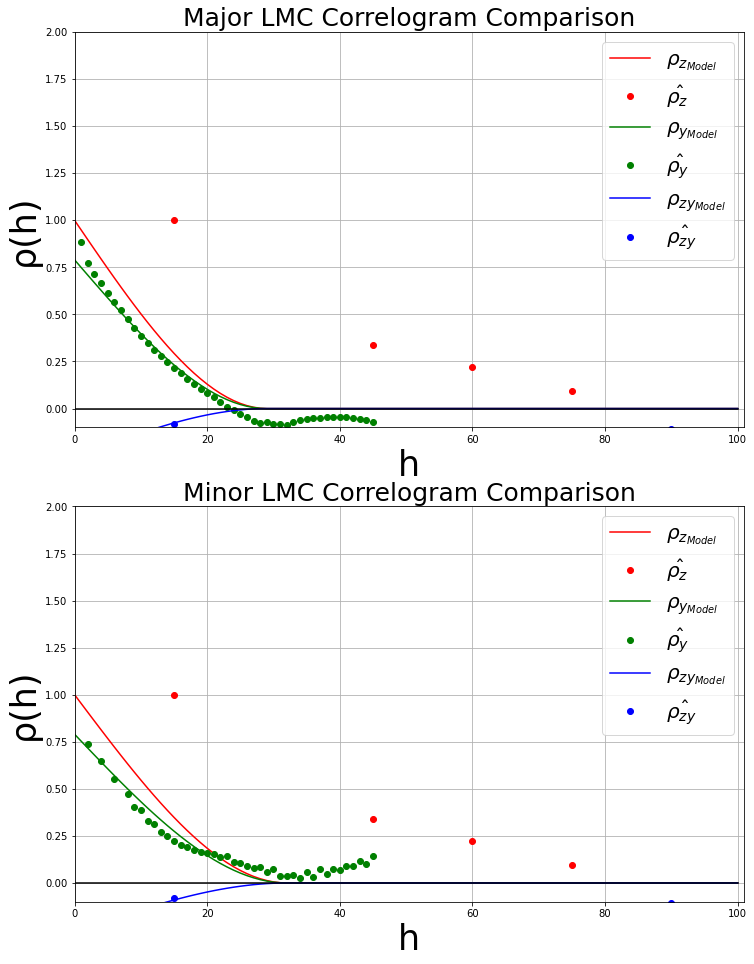

In [1233]:
labels_MM = ['$ρ_{z_{Model}}$', '$ρ_{y_{Model}}$', '$ρ_{zy_{Model}}$']
varg_type = 2  # See Correlogram Functions
k = 0
cy = np.zeros(shape=(LENGTH + 1))
cz_True = np.zeros(shape=(LENGTH + 1))
czy = np.zeros(shape=(LENGTH + 1))
nstruct = dict_secondary_LMC["nstruct"]
fig, axes = plt.subplots(2, 1, figsize=(12, 16))
for s,Dir in enumerate(["Major","Minor"]):
    for h in range(0, 101):

        cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,dict_secondary_LMC, nstruct )

        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,dict_primary_LMC, nstruct )

        czy[h]= C_ZY(np.matrix(h), np.matrix(h),varg_type,dict_cross_LMC, nstruct)

        H[h] = h
    MM_vargs = [cz_True, cy, czy]
    
    for i in range(0, 3):
        axes[s].plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 4:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "o",
                color=colors[i],
                label=labels_1[i],
            )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, 101)
    axes[s].set_ylim(-0.1, 2)
    axes[s].set_ylabel("\u03C1(h)", size=35)
    axes[s].set_xlabel("h", size=35)
    axes[s].set_title(
        Dir+" LMC Correlogram Comparison",
        size=25,
    )
    axes[s].legend(loc="best", prop={"size": 20})
    varg_type = varg_type + 1
    k += 1

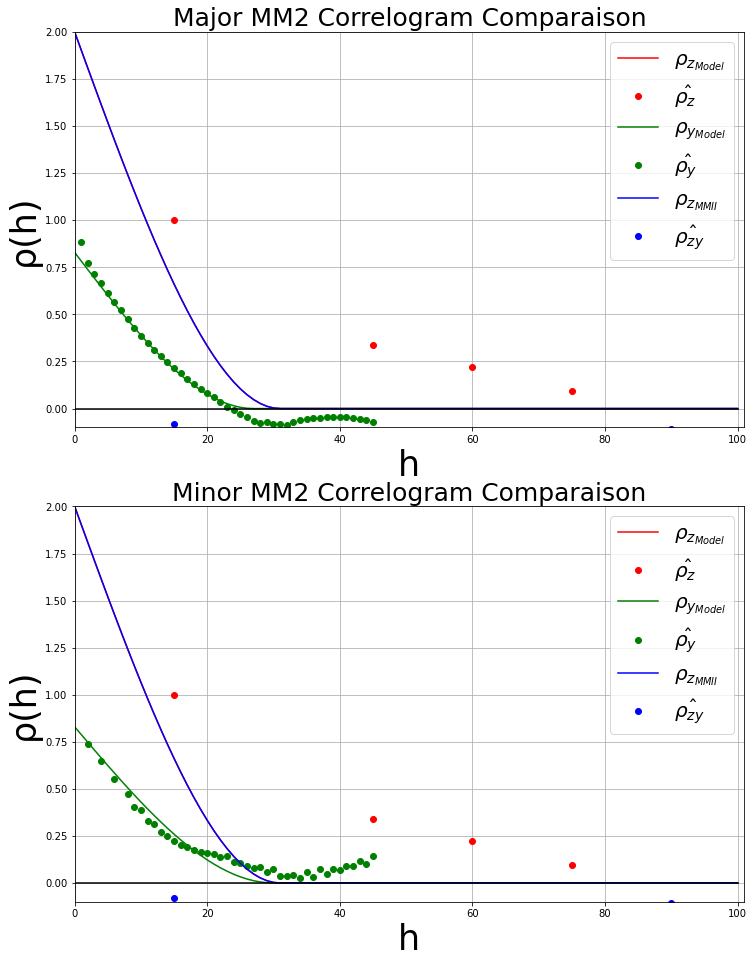

In [1234]:
labels_MM = ['$ρ_{z_{Model}}$', '$ρ_{y_{Model}}$', '$ρ_{z_{MMII}}$']
varg_type = 2  # See Correlogram Functions
k = 0
cy = np.zeros(shape=(LENGTH + 1))
cz = np.zeros(shape=(LENGTH + 1))
cr = np.zeros(shape=(LENGTH + 1))
cz_mm2 = np.zeros(shape=(LENGTH + 1))

fig, axes = plt.subplots(2, 1, figsize=(12, 16))
for s,Dir in enumerate(["Major","Minor"]):
    for h in range(0, 101):

        cy[h]= C_Y_alternate(np.matrix(h), np.matrix(h), varg_type,dict_secondary, nstruct = 1)

        cz_True[h] = C_Z_alternate(np.matrix(h), np.matrix(h),varg_type,dict_primary, nstruct = 1)

        cz[h] = C_Z_MM2(np.matrix(h), np.matrix(h), varg_type, corr,dict_secondary,dict_scalling )

        cr[h] = C_r (np.matrix(h), np.matrix(h), varg_type, dict_scalling,nstruct = 1 )

        H[h] = h
    MM_vargs = [cz_True, cy, cz]
    
    for i in range(0, 3):
        axes[s].plot(H, MM_vargs[i], color=colors[i], label=labels_MM[i])
        if (i + 1) < 4:
            var = locals()["varc_{}".format(i + 1)]
            axes[s].plot(
                var["Lag Distance"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                Sill_vals[i]
                - var["Variogram Value"][
                    var["Variogram Index"] == (varg_type - 1)
                ],
                "o",
                color=colors[i],
                label=labels_1[i],
            )

    axes[s].plot(H, ones, color="Black")
    axes[s].grid()
    axes[s].set_xlim(0, 101)
    axes[s].set_ylim(-0.1, 2)
    axes[s].set_ylabel("\u03C1(h)", size=35)
    axes[s].set_xlabel("h", size=35)
    axes[s].set_title(
        Dir+" MM2 Correlogram Comparaison",
        size=25,
    )
    axes[s].legend(loc="best", prop={"size": 20})
    varg_type = varg_type + 1
    k += 1

In [133]:
print("std of Z :", std_z)
print("std of Y :",std_y)
print("var of Z :", var_z)
print("var of Y :",var_y)
print("mean of Z :", mean_z)
print("mean of Y :",mean_y)
print("Cross Correlation coefficient :",corr,"\n")

print("Original std of Z :", original_std_z)
print("Original std of Y :",original_std_y)
print("Original var of Z :", original_var_z)
print("Original var of Y :",original_var_y)
print("Original mean of Z :", original_mean_z)
print("Original mean of Y :",original_mean_y)

std of Z : 1.0
std of Y : 1.0
var of Z : 1.0
var of Y : 1.0
mean of Z : -0.0
mean of Y : -0.0
Cross Correlation coefficient : 0.4 

Original std of Z : 0.9719001720570094
Original std of Y : 1.017889313739171
Original var of Z : 0.9445899444444446
Original var of Y : 1.0360986550244002
Original mean of Z : 3.2922222222222217
Original mean of Y : 1.8080642667645732


# Cokriging

## En cas d'interpolation à l'aide de modèle de covariance chargé

## ----------------------------------------------------

!! Modifier la condition le cas échéant !!

In [ ]:
cond_preload = True

In [34]:
# Implémentation rapide d'une cross validation
if cond_preload :
    
    requested_IR = "IR_10H22"
    TEMP = "T4"
    filename = "./varr/Estimate/Estimate_"+requested_IR+"_"+TEMP+".npy"
    dict_IR = np.load(filename,allow_pickle='TRUE').item()
    # On déballe les dicts

    dict_title = dict_IR["title"]
    df_kriging = dict_IR["df_kriging"]
    ktypes_vals_dict = dict_IR["ktypes_vals_dict"]
    dict_primary = dict_IR["dict_primary"]
    dict_cross = dict_IR["dict_cross"]
    dict_secondary = dict_IR["dict_secondary"]
    dict_scalling = dict_IR["dict_scalling"]
    dict_primary_LMC = dict_IR["dict_primary_LMC"]
    dict_cross_LMC = dict_IR["dict_cross_LMC"]
    dict_secondary_LMC = dict_IR["dict_secondary_LMC"]
    labels_MM = ['$ρ_{z_{Model}}$', '$ρ_{y_{Model}}$', '$ρ_{zy_{Model}}$']

    corr = np.corrcoef(Primary_original["Primary"], Primary_original["Secondary"])[0, 1]
    corr = float("{:.2f}".format(corr))
    print("Correlation coef :",corr)

Correlation coef : 0.72


## ----------------------------------------------------

In [35]:
Mean_Z = np.average(Primary_original["Primary"])
STD_Z = 1.0
print(Mean_Z)
print(STD_Z)

9.868649107779169e-17
1.0


In [36]:
Mean_Y = mean_y
STD_Y =  1.0
print(Mean_Y)
print(STD_Y)

0.0
1.0


## Create a KDTree to Quickly Get Nearest Points

In [37]:
from sklearn.neighbors import KDTree

In [38]:
def ech_data_kdtree(x,y,z,ech) :
    """
    Fonction qui ré-echantillonne avant l'utilisation d'un KD Tree
    """
    low_quality_secondary = pd.DataFrame()
    x_ech = x[::ech]
    low_quality_secondary["x"] = x_ech
    y_ech = y[::ech]
    low_quality_secondary["y"] = y_ech
    z_ech = z[::ech]
    low_quality_secondary["z"] = z_ech
    low_quality_secondary = low_quality_secondary.dropna(axis = 0)
    low_quality_secondary = low_quality_secondary.reset_index(drop=True)
    return low_quality_secondary,x_ech,y_ech,z_ech

In [39]:
##MATRICES NON ECHANTILLONEE
x = Secondary["X"].values
y = Secondary["Y"].values
z = Secondary["Secondary"].values

# MATRICES ECHANTILLONEES
df_kriging,x,y,z = ech_data_kdtree(x,y,z,ech = 2)

In [40]:
#Constitution d'un KD Tree, Primary data
datafl_XY = Primary_reduced[["x", "y"]].values
datafl = Primary_reduced
tree = KDTree(datafl_XY)
Pred_grid_xy = np.matrix([x, y]).T

#Constitution d'un KD Tree, Secondary data
datafl_sec = Secondary
datafl_XY_2nd = Secondary[["X", "Y"]].values
tree_2nd = KDTree(datafl_XY_2nd)

### Primary Data Search for Kriging

In [41]:
print("Nombre de point à disposition :",Primary_reduced["Primary"].shape[0])
print("Nombre de point à disposition :",datafl_sec.shape[0])

Nombre de point à disposition : 88
Nombre de point à disposition : 497912


In [42]:
k_p = Primary_reduced["Primary"].shape[0]  # number of data to use
X_Y = np.zeros((len(x), k_p, 2))
X_Y_Star = np.zeros((len(x), k_p, 2))
closematrix_Primary = np.zeros((len(x), k_p))
closematrix_Secondary = np.zeros((len(x), k_p))
neardistmatrix = np.zeros((len(x), k_p))

for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree.query(Pred_grid_xy[i : i + 1, :], k=k_p)
    a = nearest_ind.ravel()
    group = datafl.iloc[a, :]
    closematrix_Primary[i, :] = group["Primary"]
    closematrix_Secondary[i, :] = group["Secondary"]
    neardistmatrix[i, :] = nearest_dist
    X_Y[i, :, :] = group[["x", "y"]]

### Secondary Data Search for CoKriging

In [43]:
X_Y_2nd = np.zeros((len(x), k_p, 2))
closematrix_Secondary_2nd = np.zeros((len(x), k_p))
for i in range(0, len(x)):
    nearest_dist, nearest_ind = tree_2nd.query(
        Pred_grid_xy[i : i + 1, :], k=k_p
    )
    a = nearest_ind.ravel()
    group = datafl_sec.iloc[a, :]
    closematrix_Secondary_2nd[i, :] = group["Secondary"]
    X_Y_2nd[i, :, :] = group[["X", "Y"]]

## Recap des models de variogrammes

In [44]:
print("Premier Correlogram") 
print(dict_primary)

Premier Correlogram
{'a_max': [60.0], 'a_min': [60.0], 'cc': [1.68], 'vtype': array([1]), 'nstruct': 1}


In [45]:
print("Second Correlogram") 
print(dict_secondary)

Second Correlogram
{'a_max': [31.0], 'a_min': [26.0], 'cc': [0.52], 'vtype': array([1]), 'nstruct': 1}


In [46]:
print("Cross Correlogram") 
print(dict_cross)

Cross Correlogram
{'a_max': [67.0], 'a_min': [67.0], 'cc': [0.72], 'vtype': array([1]), 'nstruct': 1}


In [47]:
print("Scalling Correlogram ") 
print(dict_scalling)

Scalling Correlogram 
{'a_max': [64.0], 'a_min': [65.0], 'cc': [3.02], 'vtype': array([1])}


## Simple Cokriging

In [48]:
cz = np.zeros(shape=(k_p, k_p))
czy = np.zeros(shape=(k_p, k_p))
czy_2 = np.zeros(shape=(k_p, k_p))
cy = np.zeros(shape=(k_p, k_p))
s_m = 0
sm_idx = []
est_Full_CCK = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k_p * 2), (k_p * 2)))
    # C_ZZ
    cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary_LMC, nstruct = 1)
    # C_ZY
    czy = C_ZY(X_Y[z, :, :], X_Y_2nd[z, :, :], 0,dict_cross_LMC, nstruct = 1)
    czy_2 = C_ZY(X_Y_2nd[z, :, :], X_Y[z, :, :], 0,dict_cross_LMC, nstruct = 1)
    # C_YY
    cy = C_Y_alternate(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0, dict_secondary_LMC, nstruct = 1 )
    Kriging_Matrix = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    # print(Kriging_Matrix)
    # Set up Right Hand Sides
    r = np.zeros(shape=(k_p * 2))
    k_p_weights = np.zeros(shape=(k_p * 2))
    # RHS #C_z*
    r[0:k_p] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary_LMC, nstruct = 1 )
    # RHS #C_zy*
    r[k_p : k_p * 2] = C_ZY(
        X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1, dict_cross_LMC, nstruct = 1)
    # Calculate Kriging Weights
    try:
        k_p_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_p_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_Full_CCK[z] = 0
    # add in mean_z
    est_Full_CCK[z] = est_Full_CCK[z] + Mean_Z
    for i in range(0, k_p):
        # add in Z_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_Full_CCK[z] = (
            est_Full_CCK[z]
            + k_p_weights[i + k_p]
            * (closematrix_Secondary_2nd[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

 15%|███████████▍                                                              | 38321/248956 [02:05<11:27, 306.23it/s]


KeyboardInterrupt: 

## Intrinsic Collocated Cokriging - MM2

In [ ]:
k = k_p
s_m = 0
sm_idx = []
cz = np.zeros(shape=(k, k))
czy = np.zeros(shape=(k, k))
cy = np.zeros(shape=(k, k))
est_icck_MM2 = np.zeros(shape=(len(x)))
for z in tqdm(range(0, len(x))):
    Kriging_Matrix = np.zeros(shape=((k * 2 + 1), (k * 2 + 1)))
    # C_ZZ
    # 1
    # C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0, corr)
        
    cz = C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0,corr,dict_secondary, dict_scalling )
    # C_ZY
    # 2,#3
    # corr * C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    czy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                       dict_secondary, nstruct = 1) * corr
    # C_YY
    # 4
    # C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
    cy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                       dict_secondary, nstruct = 1)
    # Set up Right Hand Side
    # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
    Kriging_Matrix[0 : k * 2, 0 : k * 2] = np.vstack(
        (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
    )
    r = np.zeros(shape=(k * 2) + 1)
    k_weights = r
    # RHS #C_z*
    # 5
    r[0:k] = C_Z_MM2(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1, corr,dict_secondary, dict_scalling )
    # RHS #C_yz*
    # 6
    r[k : k * 2] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,
                                       dict_secondary, nstruct = 1) * corr
    )
    # RHS corr
    # 7
    r[k * 2] = corr
    # c_zy
    # 8
    Kriging_Matrix[k * 2, 0:k] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1) * corr
    )
    Kriging_Matrix[0:k, k * 2] = (
        C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1) * corr
    )
    # c_y
    # 9
    Kriging_Matrix[k * 2, k : k * 2] = C_Y_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1)
    
    Kriging_Matrix[k : k * 2, k * 2] = C_Y_alternate(
        X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                       dict_secondary, nstruct = 1)
    
    Kriging_Matrix[k * 2, k * 2] = 1
    # Kriging_Matrix.reshape(((2*k)+1),((2*k)+1))
    # Calculate Kriging Weights
    try:
        k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
    except:
        s_m = s_m + 1
        sm_idx.append(z)
        k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
    # Start Est at zero
    est_icck_MM2[z] = 0
    # add in mean_z
    est_icck_MM2[z] = est_icck_MM2[z] + Mean_Z
    # add in the Y_0
    est_icck_MM2[z] = (
        est_icck_MM2[z]
        + k_weights[k * 2] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
    )
    for i in range(0, k):
        # add in Z_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
        )
        # add in Y_i
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[i + k]
            * (closematrix_Secondary[z, i] - Mean_Y)
            / STD_Y
        )
print("There where {} Singular Matrices".format(s_m))

## Mise en place des résultats

In [ ]:
est_SCK = est_Full_CCK
est_ICCK_MM2 = est_icck_MM2

In [ ]:
ktypes = ["SCK","ICCK_MM2"]

#k_est = [est_Full_CCK,
#         est_Full_CCK_LMC,
#         est_icck_MM2
#]

k_est = [est_SCK,est_ICCK_MM2]
ktypes_vals_dict = {}
j = 0
df_kriging = df_kriging.reset_index(drop=True)
for i in ktypes:
    print(i)
    ktypes_vals_dict[i] = {
        "Estimate": k_est[j],
        "Mean": np.mean(k_est[j]),
        "Variance": np.var(k_est[j]),
        "primary": dict_primary,
        "secondary": dict_secondary,
        "cross": corr,
        
    }
    
    df_kriging["NS_Estimate_"+i] = ktypes_vals_dict[i]["Estimate"] # valeurs estimées
    df_kriging["Estimate_"+i] = ktypes_vals_dict[i]["Estimate"]* original_std_z + original_mean_z
    df_kriging["cluster_label_vis"] = Secondary["cluster_label_vis"]
    df_kriging["val_cluster_hsv"] = Secondary["val_cluster_hsv"]
    
    j = j + 1

## Affichage des différents cokrigeage

In [ ]:
filename_Sensor_txt = "./traitement_PIREN/sondes_gps_UTM31N_phase1.txt"
Sensor_df = reading_gps_file(filename_Sensor_txt)
Sensor_df = Sensor_df.loc[Sensor_df["SensorName"] != "S3-AIR"]
Target_x = np.array(Sensor_df["x"],dtype = float)
Target_y = np.array(Sensor_df["y"],dtype = float)
Sensor_Name = np.array(Sensor_df["SensorName"],dtype = str)

In [ ]:
# Aperçu de la zone d'étude 
fig,ax=plt.subplots(1,2, figsize = (20,13))
types = "ICCK_MM2"
x = df_kriging["x"].values
y = df_kriging["y"].values
Z = df_kriging["Estimate_"+types].values
img0 = ax[0].scatter(x, y,c = Z,cmap = "seismic",vmin = 0, vmax =10
)
cbar = fig.colorbar(img0, ax=ax[0])

ax[0].set_title(types)
cbar.set_label(label = "Données estimées",size = 23)
cbar.ax.tick_params(labelsize=20) 

types = "SCK"
x = df_kriging["x"].values
y = df_kriging["y"].values
Z = df_kriging["NS_Estimate_"+types].values
img0 = ax[1].scatter(x, y,c = Z,vmin = -3, vmax =3
)
cbar = fig.colorbar(img0, ax=ax[1])

ax[1].set_title(types)
cbar.set_label(label = "Données estimées",size = 23)
cbar.ax.tick_params(labelsize=20) 

# Sauvegarde des données

In [ ]:
dict_save = { "title": dict_title,
         "df_kriging" : df_kriging,
         "ktypes_vals_dict" : ktypes_vals_dict,
         "dict_primary" : dict_primary,
        "dict_cross" : dict_cross,
        "dict_secondary" : dict_secondary,
         "dict_scalling" : dict_scalling ,
         "dict_primary_LMC" : dict_primary_LMC,
         "dict_cross_LMC" : dict_cross_LMC,
         "dict_secondary_LMC" : dict_secondary_LMC,
         "corr" : corr
            }
filename = "./varr/Estimate/Estimate_"+str(REQUESTED_IR)+"_"+str(TEMP)+".npy"
np.save(filename,dict_save)

# Automatisation de la cross-verification

## La création d'un dossier "emplacement du notebook"/varr/cross_valid est nécéssaire pour le fonctionnement 

Calcul et sauvegarde des cokriging afin d'effectuer des cross-vérifications. La figure des valeurs de cross-vérification associées aux valeurs de température se trouve dans le notebook Figure_rapport.ipynb

In [87]:
requested_IR = "IR_10H22"
cond_validation = True
dict_kriging_reduce_sensor = {}
for sensor_to_reduce in Primary_original["SensorName"].values : 
    ## CHargement des modèles de covariances
    TEMP = "T4"
    filename = "./varr/Estimate/Estimate_"+requested_IR+"_"+TEMP+".npy"
    dict_IR = np.load(filename,allow_pickle='TRUE').item()
    # On déballe les dicts

    dict_title = dict_IR["title"]
    df_kriging = dict_IR["df_kriging"]
    ktypes_vals_dict = dict_IR["ktypes_vals_dict"]
    dict_primary = dict_IR["dict_primary"]
    dict_cross = dict_IR["dict_cross"]
    dict_secondary = dict_IR["dict_secondary"]
    dict_scalling = dict_IR["dict_scalling"]
    dict_primary_LMC = dict_IR["dict_primary_LMC"]
    dict_cross_LMC = dict_IR["dict_cross_LMC"]
    dict_secondary_LMC = dict_IR["dict_secondary_LMC"]
    corr = np.corrcoef(Primary_original["Primary"], Primary_original["Secondary"])[0, 1]
    corr = float("{:.2f}".format(corr))
    print("Correlation coef :",corr)

    if cond_validation :
        Primary_reduced = Primary.loc[Primary["SensorName"] != sensor_to_reduce].reset_index(drop=True)

    Mean_Z = np.average(Primary_original["Primary"])
    STD_Z = 1.0
    Mean_Y = np.average(Secondary["Secondary"])
    STD_Y =  1.0

    ##MATRICES NON ECHANTILLONEE
    x = Secondary["X"].values
    y = Secondary["Y"].values
    z = Secondary["Secondary"].values

    # MATRICES ECHANTILLONEES
    df_kriging,x,y,z = ech_data_kdtree(x,y,z,ech = 2)

    #Constitution d'un KD Tree, Primary data
    datafl_XY = Primary_reduced[["x", "y"]].values
    datafl = Primary_reduced
    tree = KDTree(datafl_XY)
    Pred_grid_xy = np.matrix([x, y]).T

    #Constitution d'un KD Tree, Secondary data
    datafl_sec = Secondary
    datafl_XY_2nd = Secondary[["X", "Y"]].values
    tree_2nd = KDTree(datafl_XY_2nd)

    k_p = Primary_reduced["Primary"].shape[0]  # number of data to use
    X_Y = np.zeros((len(x), k_p, 2))
    X_Y_Star = np.zeros((len(x), k_p, 2))
    closematrix_Primary = np.zeros((len(x), k_p))
    closematrix_Secondary = np.zeros((len(x), k_p))
    neardistmatrix = np.zeros((len(x), k_p))

    # Primary search
    for i in range(0, len(x)):
        nearest_dist, nearest_ind = tree.query(Pred_grid_xy[i : i + 1, :], k=k_p)
        a = nearest_ind.ravel()
        group = datafl.iloc[a, :]
        closematrix_Primary[i, :] = group["Primary"]
        closematrix_Secondary[i, :] = group["Secondary"]
        neardistmatrix[i, :] = nearest_dist
        X_Y[i, :, :] = group[["x", "y"]]

    # Secondary search
    X_Y_2nd = np.zeros((len(x), k_p, 2))
    closematrix_Secondary_2nd = np.zeros((len(x), k_p))
    for i in range(0, len(x)):
        nearest_dist, nearest_ind = tree_2nd.query(
            Pred_grid_xy[i : i + 1, :], k=k_p
        )
        a = nearest_ind.ravel()
        group = datafl_sec.iloc[a, :]
        closematrix_Secondary_2nd[i, :] = group["Secondary"]
        X_Y_2nd[i, :, :] = group[["X", "Y"]]

    ## SIMPLE COKRIGING 
    cz = np.zeros(shape=(k_p, k_p))
    czy = np.zeros(shape=(k_p, k_p))
    czy_2 = np.zeros(shape=(k_p, k_p))
    cy = np.zeros(shape=(k_p, k_p))
    s_m = 0
    sm_idx = []
    est_Full_CCK = np.zeros(shape=(len(x)))
    for z in tqdm(range(0, len(x))):
        Kriging_Matrix = np.zeros(shape=((k_p * 2), (k_p * 2)))
        # C_ZZ
        cz = C_Z_alternate(X_Y[z, :, :], X_Y[z, :, :],0,dict_primary_LMC, nstruct = 1)
        # C_ZY
        czy = C_ZY(X_Y[z, :, :], X_Y_2nd[z, :, :], 0,dict_cross_LMC, nstruct = 1)
        czy_2 = C_ZY(X_Y_2nd[z, :, :], X_Y[z, :, :], 0,dict_cross_LMC, nstruct = 1)
        # C_YY
        cy = C_Y_alternate(X_Y_2nd[z, :, :], X_Y_2nd[z, :, :], 0, dict_secondary_LMC, nstruct = 1 )
        Kriging_Matrix = np.vstack(
            (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
        )
        # print(Kriging_Matrix)
        # Set up Right Hand Sides
        r = np.zeros(shape=(k_p * 2))
        k_p_weights = np.zeros(shape=(k_p * 2))
        # RHS #C_z*
        r[0:k_p] = C_Z_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1,dict_primary_LMC, nstruct = 1 )
        # RHS #C_zy*
        r[k_p : k_p * 2] = C_ZY(
            X_Y_2nd[z, :, :], np.tile(Pred_grid_xy[z], (k_p, 1)), 1, dict_cross_LMC, nstruct = 1)
        # Calculate Kriging Weights
        try:
            k_p_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
        except:
            s_m = s_m + 1
            sm_idx.append(z)
            k_p_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
        # Start Est at zero
        est_Full_CCK[z] = 0
        # add in mean_z
        est_Full_CCK[z] = est_Full_CCK[z] + Mean_Z
        for i in range(0, k_p):
            # add in Z_i
            est_Full_CCK[z] = (
                est_Full_CCK[z]
                + k_p_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
            )
            # add in Y_i
            est_Full_CCK[z] = (
                est_Full_CCK[z]
                + k_p_weights[i + k_p]
                * (closematrix_Secondary_2nd[z, i] - Mean_Y)
                / STD_Y
            )
    print("There where {} Singular Matrices".format(s_m))

    ## Intrinsic Collocated Cokriging

    k = k_p
    s_m = 0
    sm_idx = []
    cz = np.zeros(shape=(k, k))
    czy = np.zeros(shape=(k, k))
    cy = np.zeros(shape=(k, k))
    est_icck_MM2 = np.zeros(shape=(len(x)))
    for z in tqdm(range(0, len(x))):
        Kriging_Matrix = np.zeros(shape=((k * 2 + 1), (k * 2 + 1)))
        # C_ZZ
        # 1
        # C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0, corr)

        cz = C_Z_MM2(X_Y[z, :, :], X_Y[z, :, :], 0,corr,dict_secondary, dict_scalling )
        # C_ZY
        # 2,#3
        # corr * C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
        czy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                           dict_secondary, nstruct = 1) * corr
        # C_YY
        # 4
        # C_Y(X_Y[z, :, :], X_Y[z, :, :], 0)
        cy = C_Y_alternate(X_Y[z, :, :], X_Y[z, :, :], 0,
                                           dict_secondary, nstruct = 1)
        # Set up Right Hand Side
        # print(Kriging_Matrix.reshape(((2*k)+1),((2*k)+1)))
        Kriging_Matrix[0 : k * 2, 0 : k * 2] = np.vstack(
            (np.hstack((cz, czy)), np.hstack((czy.T, cy)))
        )
        r = np.zeros(shape=(k * 2) + 1)
        k_weights = r
        # RHS #C_z*
        # 5
        r[0:k] = C_Z_MM2(
            X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1, corr,dict_secondary, dict_scalling )
        # RHS #C_yz*
        # 6
        r[k : k * 2] = (
            C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)), 1,
                                           dict_secondary, nstruct = 1) * corr
        )
        # RHS corr
        # 7
        r[k * 2] = corr
        # c_zy
        # 8
        Kriging_Matrix[k * 2, 0:k] = (
            C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                           dict_secondary, nstruct = 1) * corr
        )
        Kriging_Matrix[0:k, k * 2] = (
            C_Y_alternate(X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                           dict_secondary, nstruct = 1) * corr
        )
        # c_y
        # 9
        Kriging_Matrix[k * 2, k : k * 2] = C_Y_alternate(
            X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                           dict_secondary, nstruct = 1)

        Kriging_Matrix[k : k * 2, k * 2] = C_Y_alternate(
            X_Y[z, :, :], np.tile(Pred_grid_xy[z], (k, 1)),1,
                                           dict_secondary, nstruct = 1)

        Kriging_Matrix[k * 2, k * 2] = 1
        # Kriging_Matrix.reshape(((2*k)+1),((2*k)+1))
        # Calculate Kriging Weights
        try:
            k_weights = np.dot(np.linalg.inv(Kriging_Matrix), r)
        except:
            s_m = s_m + 1
            sm_idx.append(z)
            k_weights = np.dot(scipy.linalg.pinv(Kriging_Matrix), r)
        # Start Est at zero
        est_icck_MM2[z] = 0
        # add in mean_z
        est_icck_MM2[z] = est_icck_MM2[z] + Mean_Z
        # add in the Y_0
        est_icck_MM2[z] = (
            est_icck_MM2[z]
            + k_weights[k * 2] * (datafl_sec["Secondary"][z] - Mean_Y) / STD_Y
        )
        for i in range(0, k):
            # add in Z_i
            est_icck_MM2[z] = (
                est_icck_MM2[z]
                + k_weights[i] * (closematrix_Primary[z, i] - Mean_Z) / STD_Z
            )
            # add in Y_i
            est_icck_MM2[z] = (
                est_icck_MM2[z]
                + k_weights[i + k]
                * (closematrix_Secondary[z, i] - Mean_Y)
                / STD_Y
            )
    print("There where {} Singular Matrices".format(s_m))

    est_SCK = est_Full_CCK
    est_ICCK_MM2 = est_icck_MM2
    ktypes = ["SCK","ICCK_MM2"]
    k_est = [est_SCK,est_ICCK_MM2]
    ktypes_vals_dict = {}
    j = 0
    df_kriging = df_kriging.reset_index(drop=True)
    for i in ktypes:
        print(i)
        ktypes_vals_dict[i] = {
            "Estimate": k_est[j],
            "Mean": np.mean(k_est[j]),
            "Variance": np.var(k_est[j]),
            "primary": dict_primary,
            "secondary": dict_secondary,
            "cross": corr,

        }

        df_kriging["NS_Estimate_"+i] = ktypes_vals_dict[i]["Estimate"] # valeurs estimées
        df_kriging["Estimate_"+i] = ktypes_vals_dict[i]["Estimate"]* original_std_z + original_mean_z
        df_kriging["cluster_label_vis"] = Secondary["cluster_label_vis"]
        df_kriging["val_cluster_hsv"] = Secondary["val_cluster_hsv"]

        j = j + 1

    sensor_x = Primary_original.loc[Primary_original["SensorName"] == sensor_to_reduce]["x"].astype(float).values[0]
    sensor_y = Primary_original.loc[Primary_original["SensorName"] == sensor_to_reduce]["y"].astype(float).values[0]

    ## Query search autour des sondes
    exp =  "(x >= " + str(sensor_x-0.5) + ' & ' + "x <= " + str(sensor_x+0.5) + " )& ("
    exp += "y >= " + str(sensor_y-0.5) + ' & ' + "y <= " + str(sensor_y+0.5) + " ) " 
    nearby_sensor = df_kriging.query(exp)

    dict_kriging_reduce_sensor[sensor_to_reduce] = {"df_kriging" : df_kriging,
                                              "ktypes_vals_dict" : ktypes_vals_dict,
                                               "nearby_sensor" : nearby_sensor,
                                              }

    Primary_original.loc[Primary_original["SensorName"] == sensor_to_reduce]
    filename = "./varr/cross_valid/sensor_"+sensor_to_reduce+"_"+str(requested_IR)+"_"+str(TEMP)+".npy"
    np.save(filename,dict_kriging_reduce_sensor)

Correlation coef : 0.72


  0%|                                                                             | 14/124478 [00:00<15:57, 129.97it/s]

There where 0 Singular Matrices


100%|█████████████████████████████████████████████████████████████████████████| 124478/124478 [13:25<00:00, 154.60it/s]


There where 0 Singular Matrices
SCK
ICCK_MM2
Correlation coef : 0.72


  0%|                                                                             | 16/124478 [00:00<13:26, 154.26it/s]

There where 0 Singular Matrices


100%|█████████████████████████████████████████████████████████████████████████| 124478/124478 [11:41<00:00, 177.37it/s]


There where 0 Singular Matrices
SCK
ICCK_MM2
Correlation coef : 0.72


  0%|                                                                             | 17/124478 [00:00<12:32, 165.49it/s]

There where 0 Singular Matrices


100%|█████████████████████████████████████████████████████████████████████████| 124478/124478 [11:34<00:00, 179.11it/s]


There where 0 Singular Matrices
SCK
ICCK_MM2
Correlation coef : 0.72


  0%|                                                                             | 21/124478 [00:00<10:14, 202.46it/s]

There where 0 Singular Matrices


100%|█████████████████████████████████████████████████████████████████████████| 124478/124478 [11:22<00:00, 182.47it/s]


There where 0 Singular Matrices
SCK
ICCK_MM2
Correlation coef : 0.72


  0%|                                                                             | 18/124478 [00:00<11:33, 179.56it/s]

There where 0 Singular Matrices


100%|█████████████████████████████████████████████████████████████████████████| 124478/124478 [12:28<00:00, 166.40it/s]


There where 0 Singular Matrices
SCK
ICCK_MM2
Correlation coef : 0.72


  0%|                                                                             | 18/124478 [00:00<11:50, 175.22it/s]

There where 0 Singular Matrices


100%|█████████████████████████████████████████████████████████████████████████| 124478/124478 [11:25<00:00, 181.70it/s]


There where 0 Singular Matrices
SCK
ICCK_MM2
Correlation coef : 0.72


  0%|                                                                             | 14/124478 [00:00<14:55, 138.99it/s]

There where 0 Singular Matrices


100%|█████████████████████████████████████████████████████████████████████████| 124478/124478 [14:46<00:00, 140.38it/s]


There where 0 Singular Matrices
SCK
ICCK_MM2
Correlation coef : 0.72


  0%|                                                                             | 14/124478 [00:00<14:55, 138.99it/s]

There where 0 Singular Matrices


100%|█████████████████████████████████████████████████████████████████████████| 124478/124478 [12:59<00:00, 159.71it/s]


There where 0 Singular Matrices
SCK
ICCK_MM2
Correlation coef : 0.72


  0%|                                                                             | 22/124478 [00:00<09:27, 219.47it/s]

There where 0 Singular Matrices


100%|█████████████████████████████████████████████████████████████████████████| 124478/124478 [08:12<00:00, 252.67it/s]


There where 0 Singular Matrices
SCK
ICCK_MM2
